In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)
import glob
!whoami

ihme\yongqx2


In [2]:
# change the working directory to breast cancer model 2 outputs
%cd C:/Users/yongqx2/Desktop/Sim Science/Swiss RE Cancer/count_data_model_2
#%cd /ihme/costeffectiveness/results/vivarium_csu_swissre_cancer/v2.0_screening/swissre_coverage/2020_06_28_20_22_51/count_data

C:\Users\yongqx2\Desktop\Sim Science\Swiss RE Cancer\count_data_model_2


In [3]:
fnames = glob.glob('*.csv')
df = {}
for fname in fnames:
    df[fname[:-4]] = pd.read_csv(fname).iloc[:, 1:]

In [4]:
df.keys()

dict_keys(['deaths', 'person_time', 'population', 'state_person_time', 'transition_count', 'ylds', 'ylls'])

In [5]:
cols = ['age_cohort', 'sex', 'year', 'input_draw', 'cause', 'measure']

# Deaths

In [6]:
# deaths_due_to_all_causes = deaths_due_to_breast_cancer + deaths_due_to_other_causes
deaths_all_causes = (df['deaths']
                     .groupby([c for c in cols if c != 'cause'])
                     .value.sum()
                     .reset_index())
deaths_all_causes['cause'] = 'all_causes'
deaths = pd.concat([deaths_all_causes, df['deaths']], ignore_index=True)

# csmr
csmr = (deaths.drop(columns='measure').set_index([c for c in cols if c != 'measure'])
        .div(df['person_time'].drop(columns='measure').set_index([c for c in cols if c not in ['cause', 'measure']]))
        .mul(100_000)
        .reset_index())
csmr_summary = (csmr
                .groupby([c for c in cols if c not in ['input_draw', 'measure']])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
csmr

age_cohort     sex  year  input_draw          cause        value
0      1935_to_1940  female  2020           3     all_causes  7510.806312
1      1935_to_1940  female  2020           3  breast_cancer    51.093920
2      1935_to_1940  female  2020           3   other_causes  7459.712391
3      1935_to_1940  female  2020          21     all_causes  7742.275281
...             ...     ...   ...         ...            ...          ...
79796  2000_to_2005    male  2038         973   other_causes   145.678899
79797  2000_to_2005    male  2038         990     all_causes   146.386140
79798  2000_to_2005    male  2038         990  breast_cancer     0.000000
79799  2000_to_2005    male  2038         990   other_causes   146.386140

[79800 rows x 6 columns]

In [7]:
def plot_over_year(data: pd.DataFrame, measure: str, col_name: str, select: str):
    data_sub = data[getattr(data, col_name) == select]
    #ymax= data_sub['97.5%'].max()
    
    plt.figure(figsize=(16, 10), dpi=150)
    
    for i, age_cohort in enumerate(data_sub.age_cohort.unique()[::-1]):
        plt.subplot(4, 4, i+1)
        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        data_age_group = data_sub[data_sub.age_cohort == age_cohort]
        for sex in ['female', 'male']:
            data_sex = data_age_group[data_age_group.sex == sex]
            plt.plot(data_sex.year, data_sex['mean'], label=sex)
            plt.fill_between(data_sex.year, data_sex['2.5%'], data_sex['97.5%'], alpha=.3)
            #plt.ylim(ymax=ymax)
            plt.title(age_cohort)
    plt.legend(loc=(1.1, .1))
    if measure == 'Deaths':
        plt.suptitle(f'{measure} due to {select} (per 100,000 PY)', y=0.95, fontsize=14)
    elif measure == 'Incidence':
        if select == 'susceptible_to_breast_cancer_to_ductal_carcinoma_in_situ_event_count':
            select = 'ductal_carcinoma_in_situ'
        elif select == 'susceptible_to_breast_cancer_to_lobular_carcinoma_in_situ_event_count':
            select = 'lobular_carcinoma_in_situ'
        elif select == 'breast_carcinoma_in_situ_to_breast_cancer_event_count':
            select = 'breast_cancer'
        else: select = select.split('_event_count')[0]
        plt.suptitle(f'{measure} of {select} (per 100,000 PY)', y=0.95, fontsize=14)
    else:
        plt.suptitle(f'{measure} of {select} (%)', y=0.95, fontsize=14)

In [8]:
def plot_over_age(data: pd.DataFrame, measure: str, col_name: str, select: str):
    data_sub = data[getattr(data, col_name) == select]
    ymax= data_sub['mean'].max()
    
    plt.figure(figsize=(16, 6), dpi=150)
    
    for i, sex in enumerate(['female', 'male']):
        plt.subplot(1, 2, i+1)
        plt.subplots_adjust(wspace=0.3)
        data_sex = data_sub[data_sub.sex == sex]
        for year in range(2020, 2039):
            data_year = data_sex[data_sex.year == year]
            data_year = data_year.sort_values(by='age_cohort', ascending=False)
            plt.plot(data_year.age_cohort, data_year['mean'], marker='o', label=year)
            #plt.fill_between(data_year.age_cohort, data_year['2.5%'], data_year['97.5%'], alpha=.3)
        plt.ylim(ymax=ymax)
        plt.title(sex)
        plt.xticks(rotation=60)
        plt.xlabel('Birth cohort')
    plt.legend(loc=(1.1, .1))
        
    
    if measure == 'Deaths':
        plt.suptitle(f'{measure} due to {select} (per 100,000 PY)', y=1, fontsize=14)
    elif measure == 'Incidence':
        if select == 'susceptible_to_breast_cancer_to_ductal_carcinoma_in_situ_event_count':
            select = 'ductal_carcinoma_in_situ'
        elif select == 'susceptible_to_breast_cancer_to_lobular_carcinoma_in_situ_event_count':
            select = 'lobular_carcinoma_in_situ'
        elif select == 'breast_carcinoma_in_situ_to_breast_cancer_event_count':
            select = 'breast_cancer'
        else: select = select.split('_event_count')[0]
        plt.suptitle(f'{measure} of {select} (per 100,000 PY)', y=1, fontsize=14)
    else:
        plt.suptitle(f'{measure} of {select} (%)', y=1, fontsize=14)

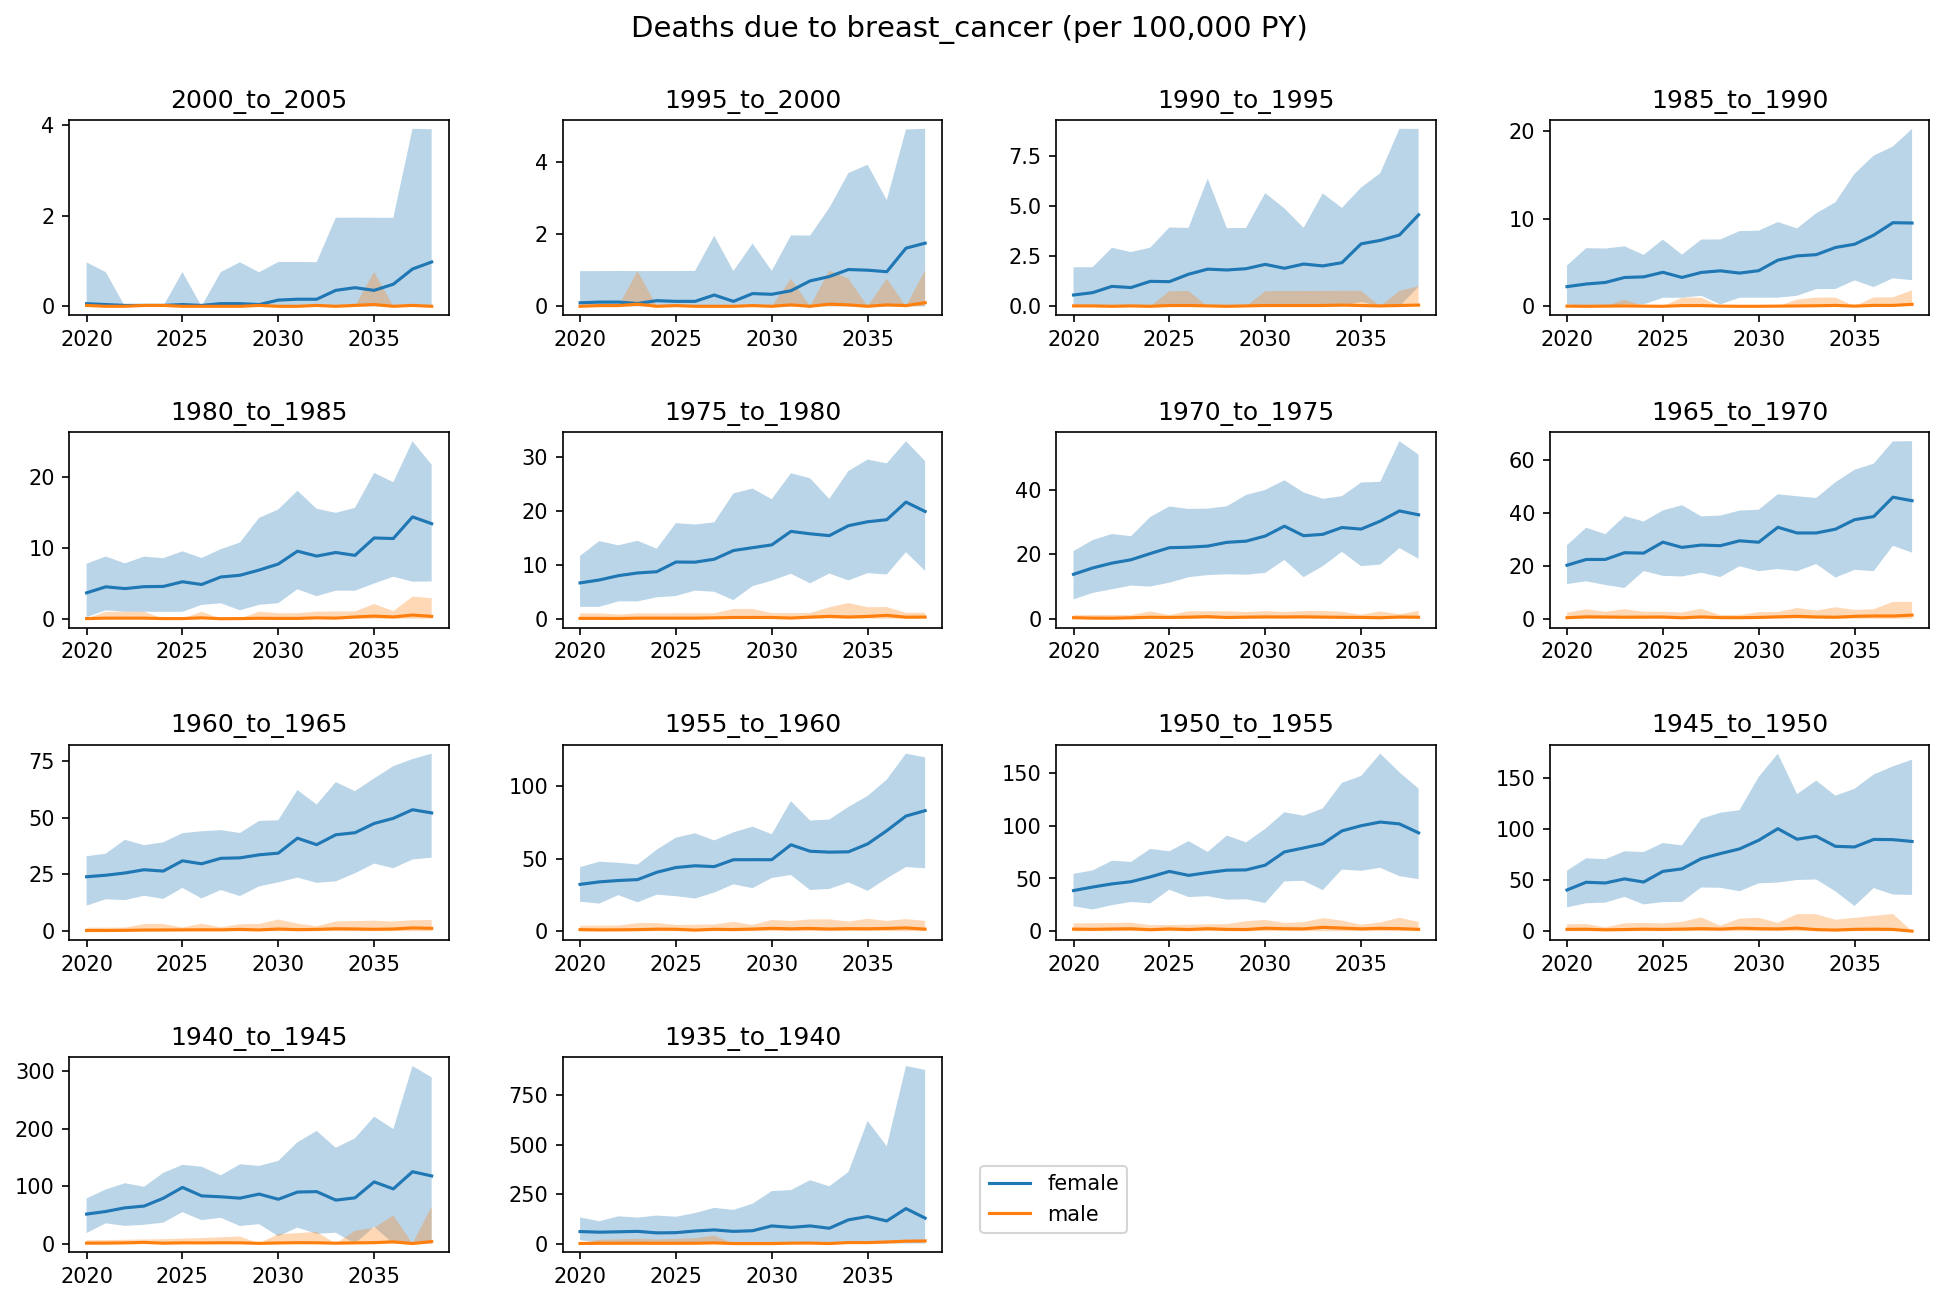

In [9]:
plot_over_year(csmr_summary, 'Deaths', 'cause', 'breast_cancer')

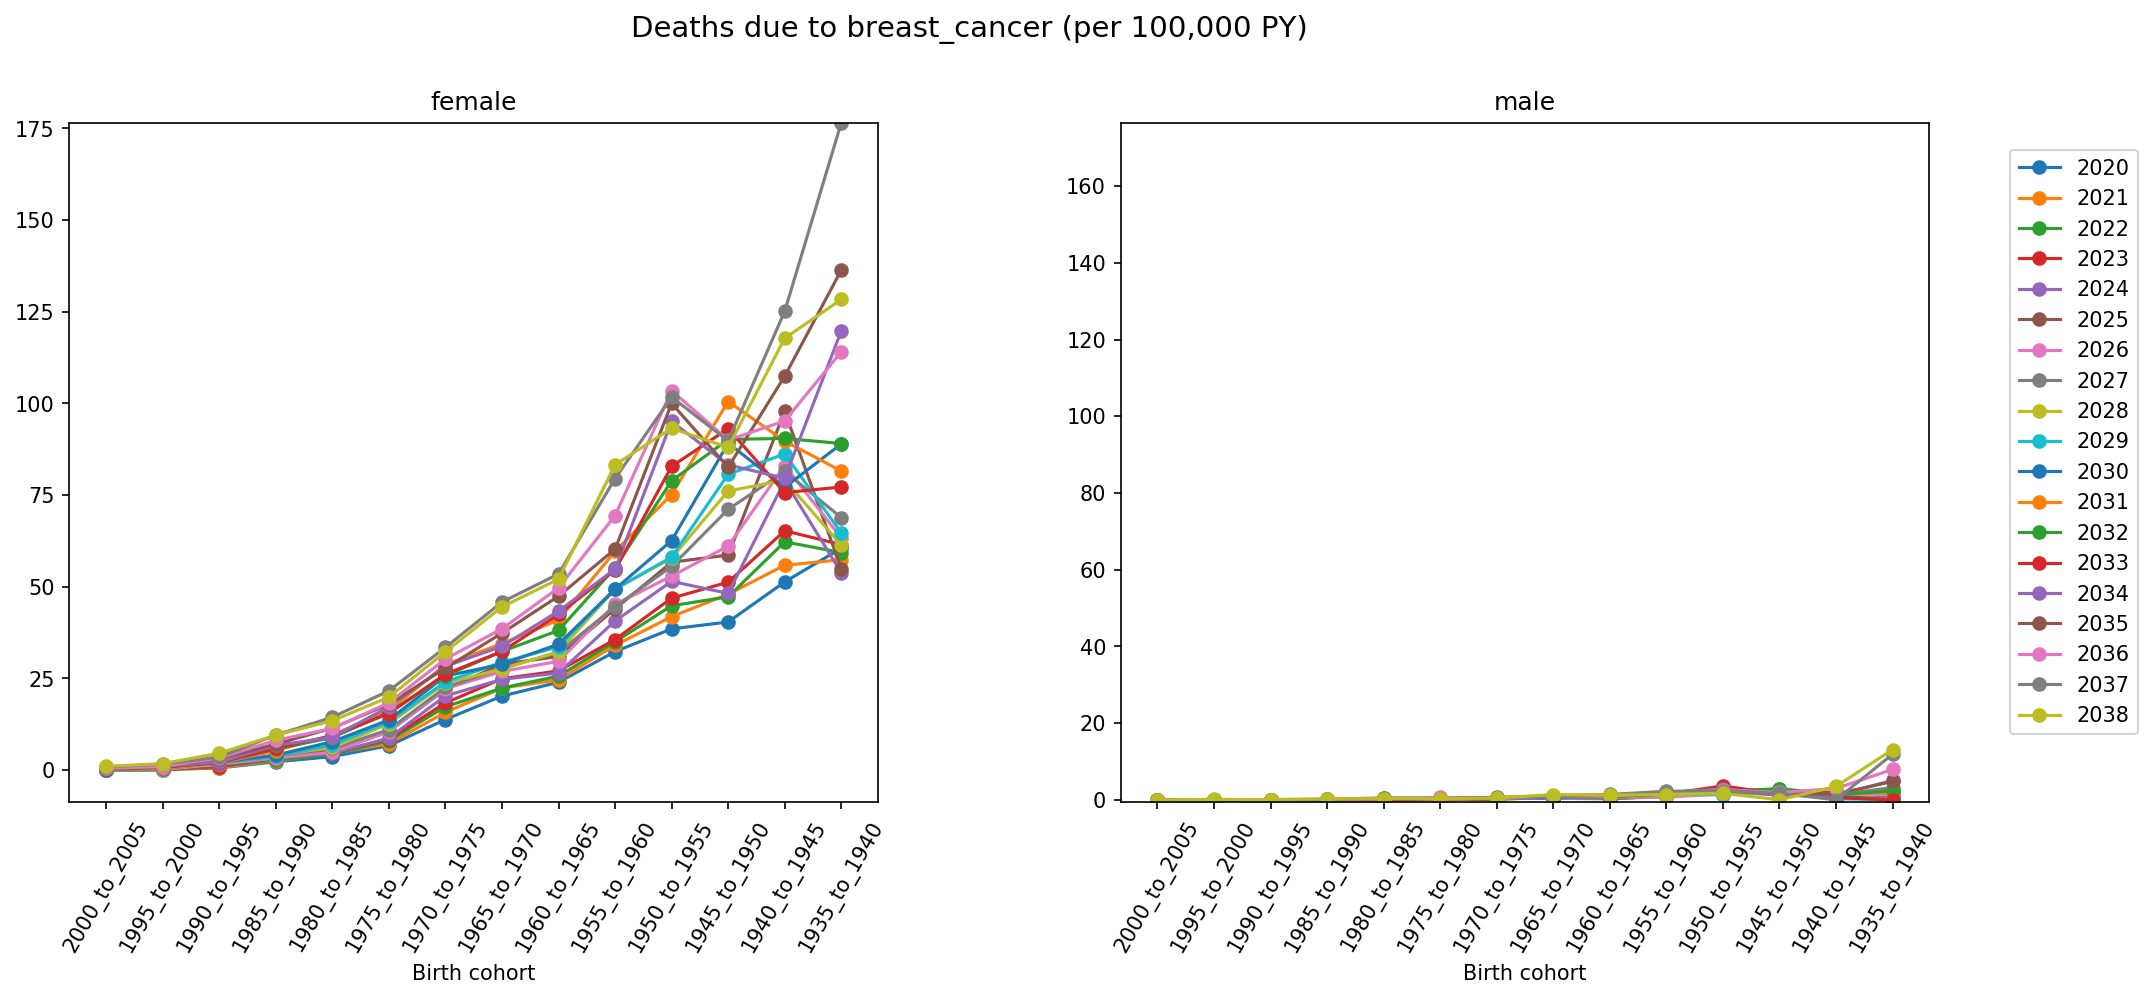

In [10]:
plot_over_age(csmr_summary, 'Deaths', 'cause', 'breast_cancer')

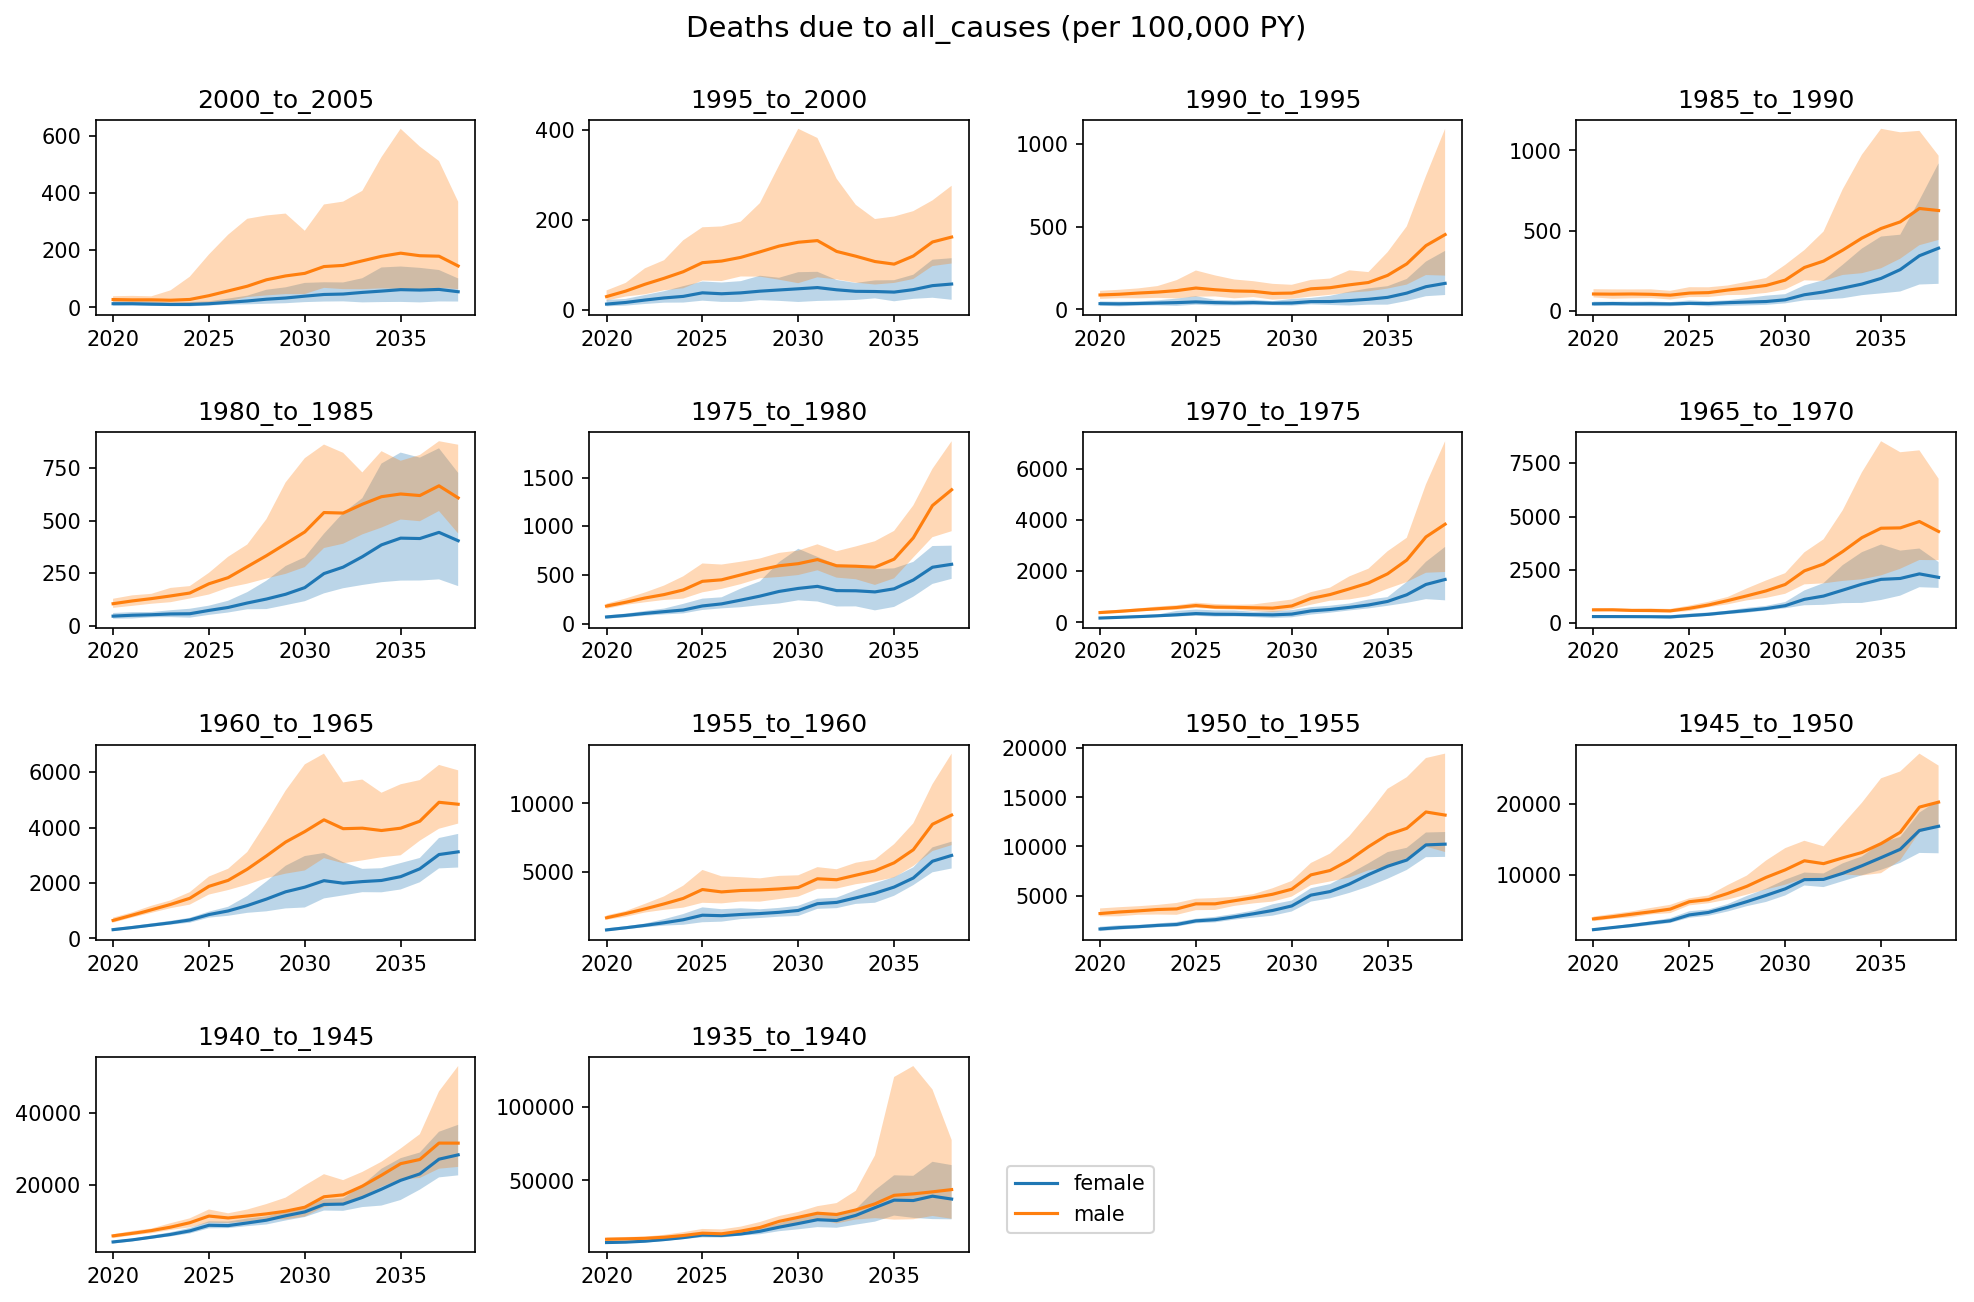

In [11]:
plot_over_year(csmr_summary, 'Deaths', 'cause', 'all_causes')

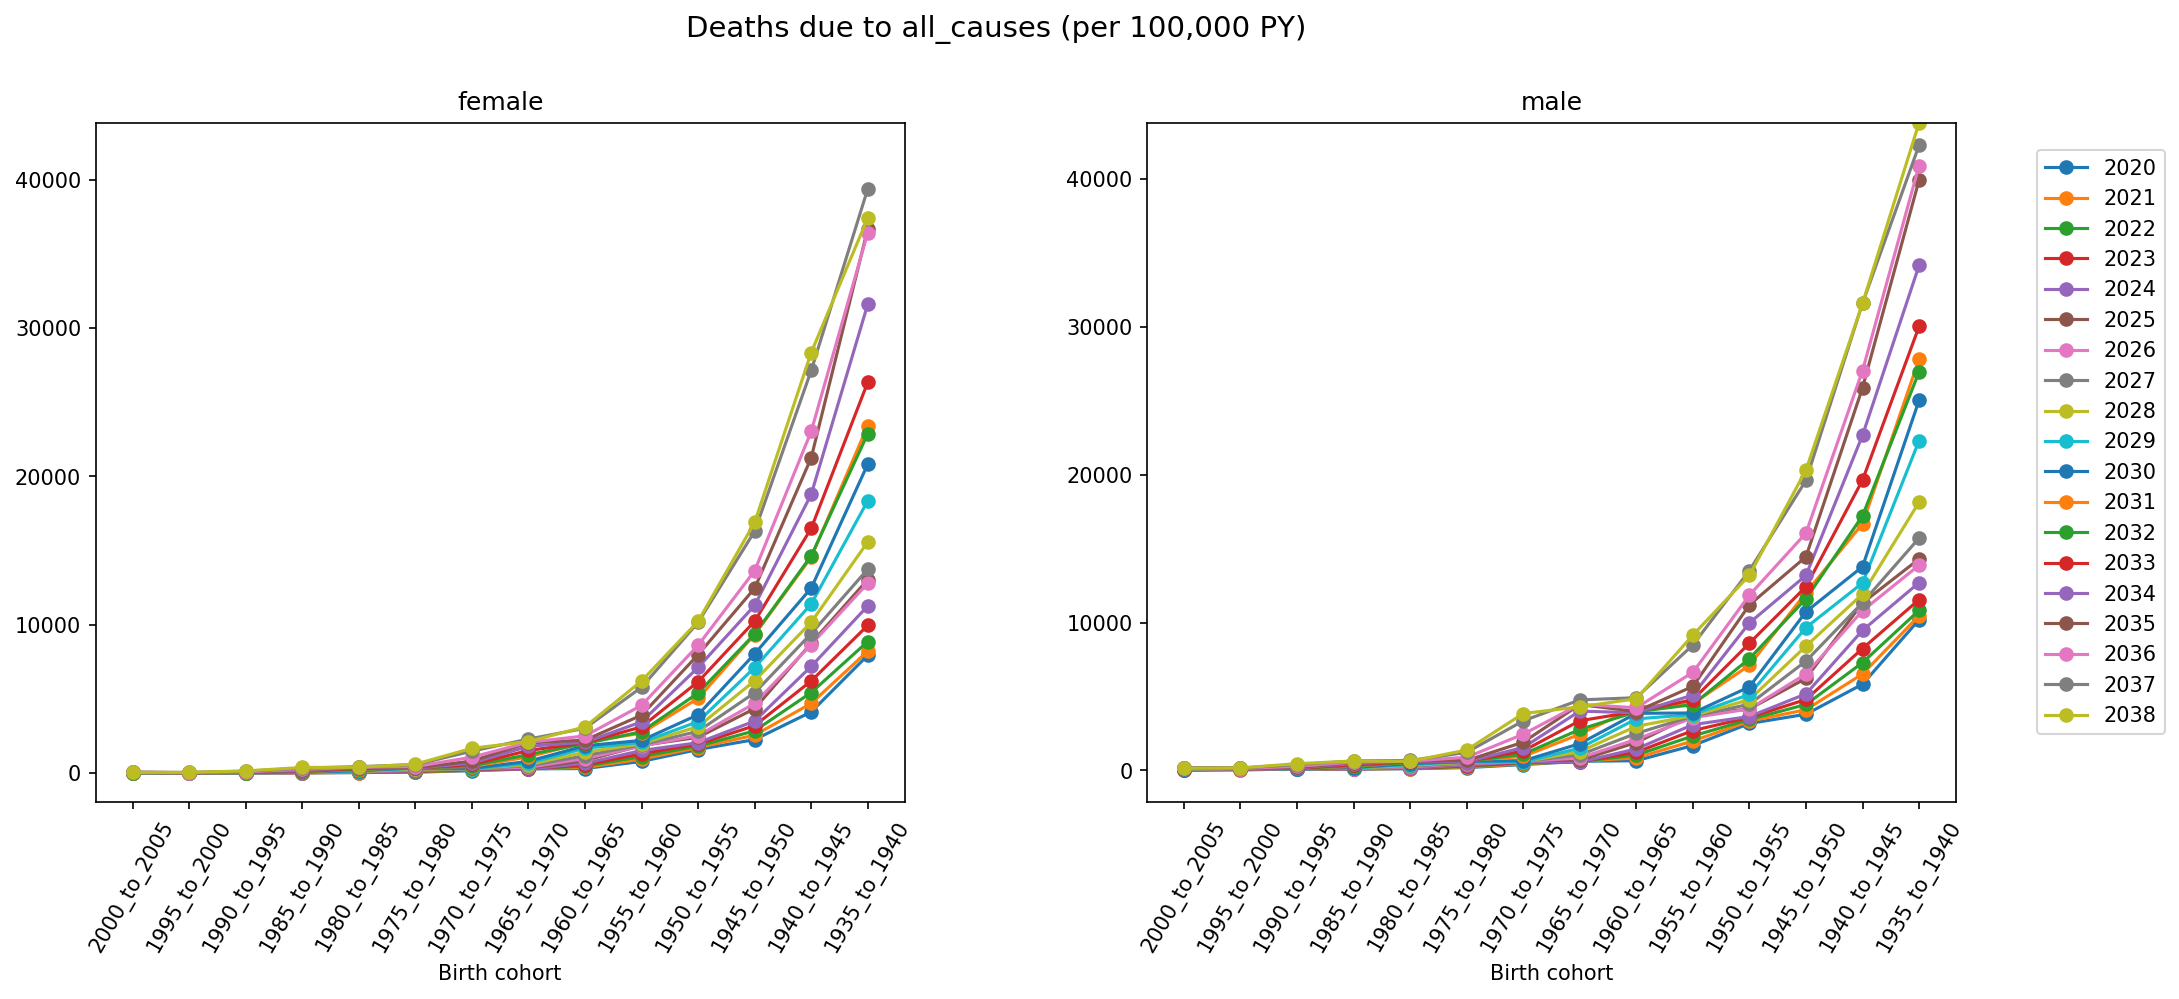

In [12]:
plot_over_age(csmr_summary, 'Deaths', 'cause', 'all_causes')

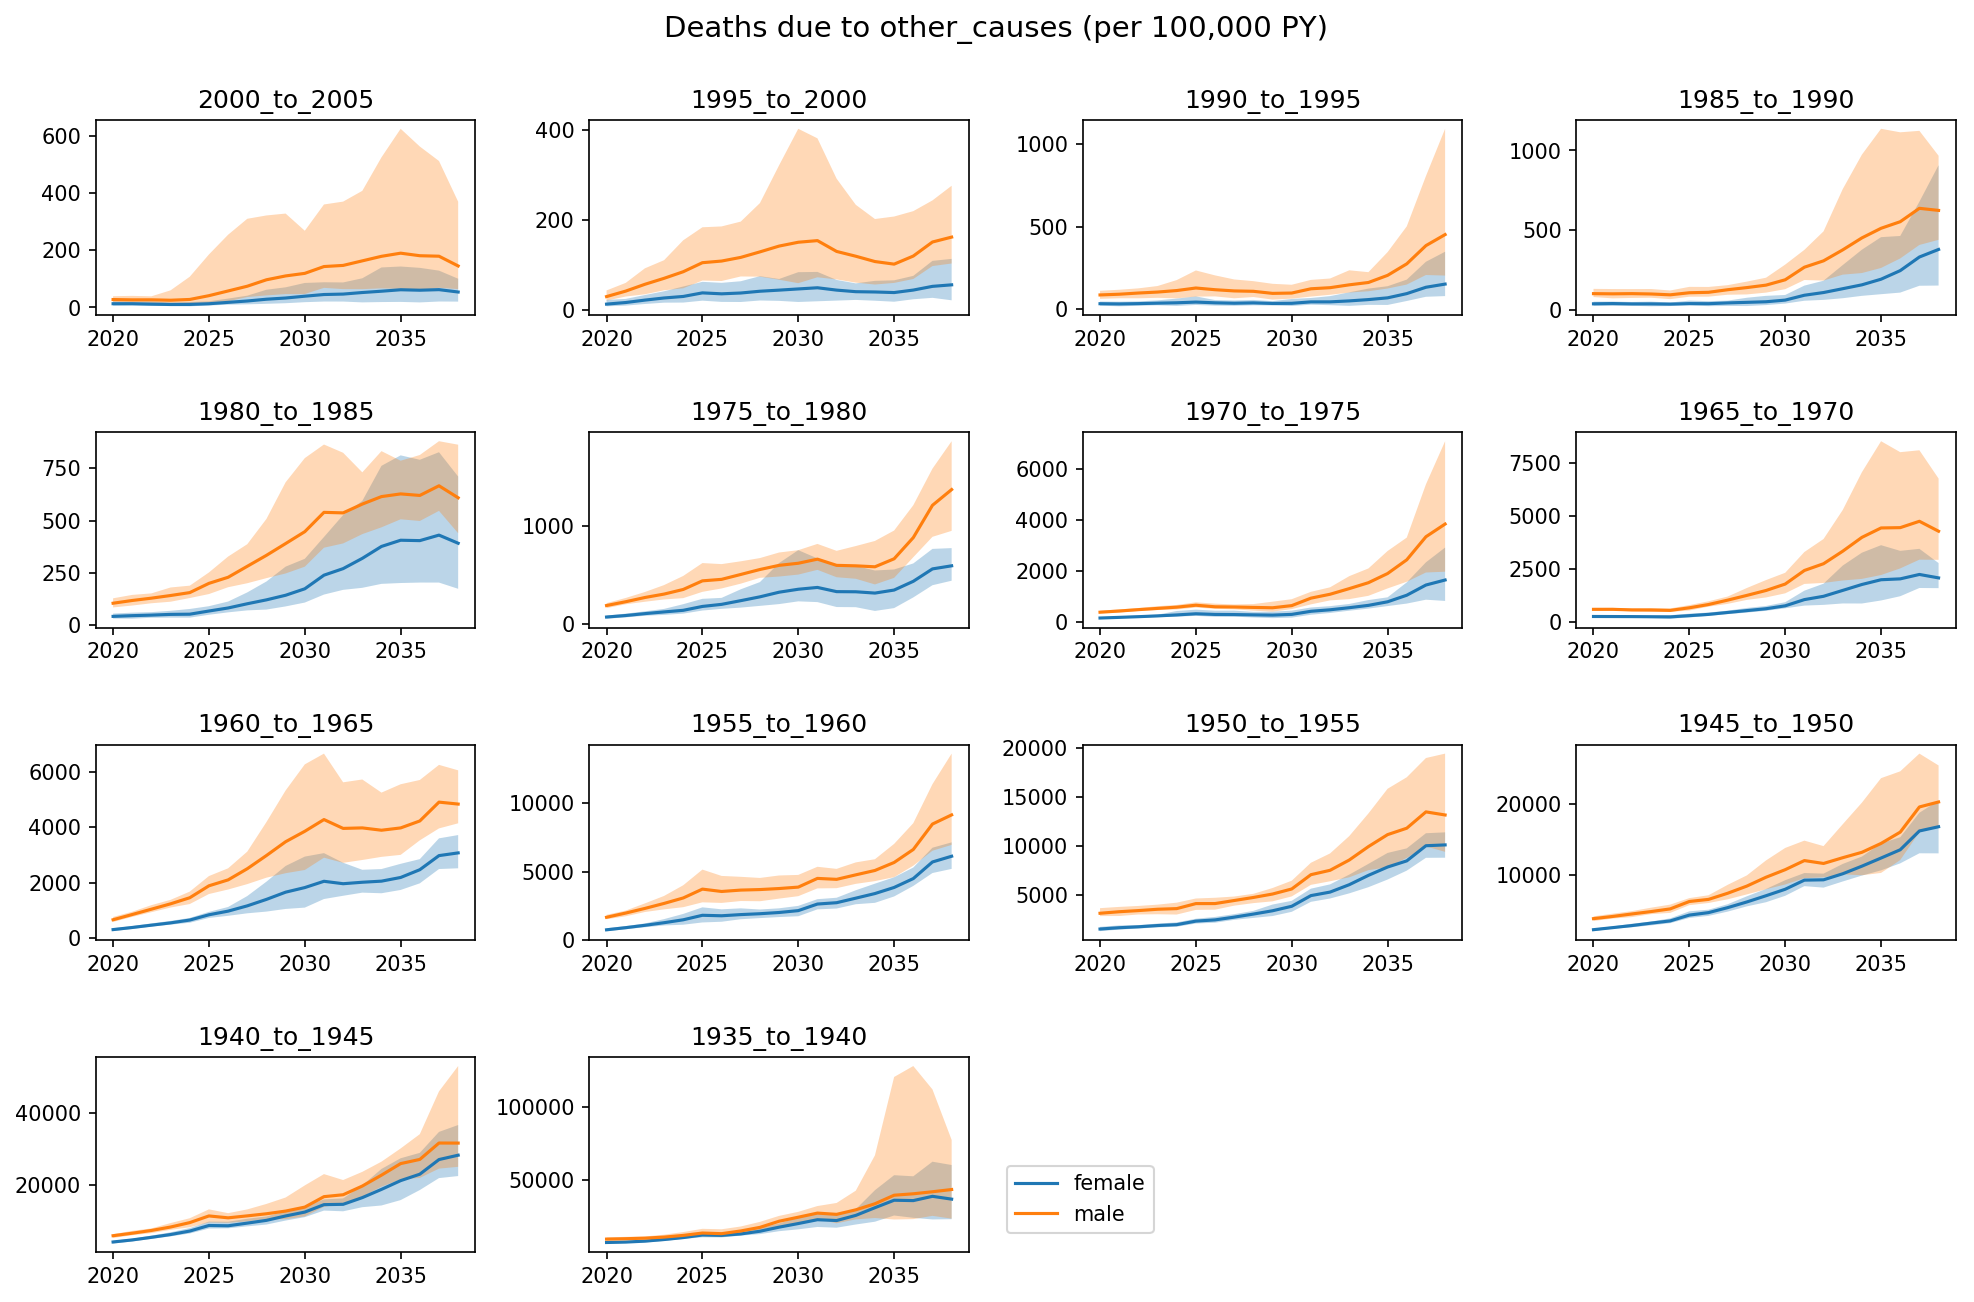

In [13]:
plot_over_year(csmr_summary, 'Deaths', 'cause', 'other_causes')

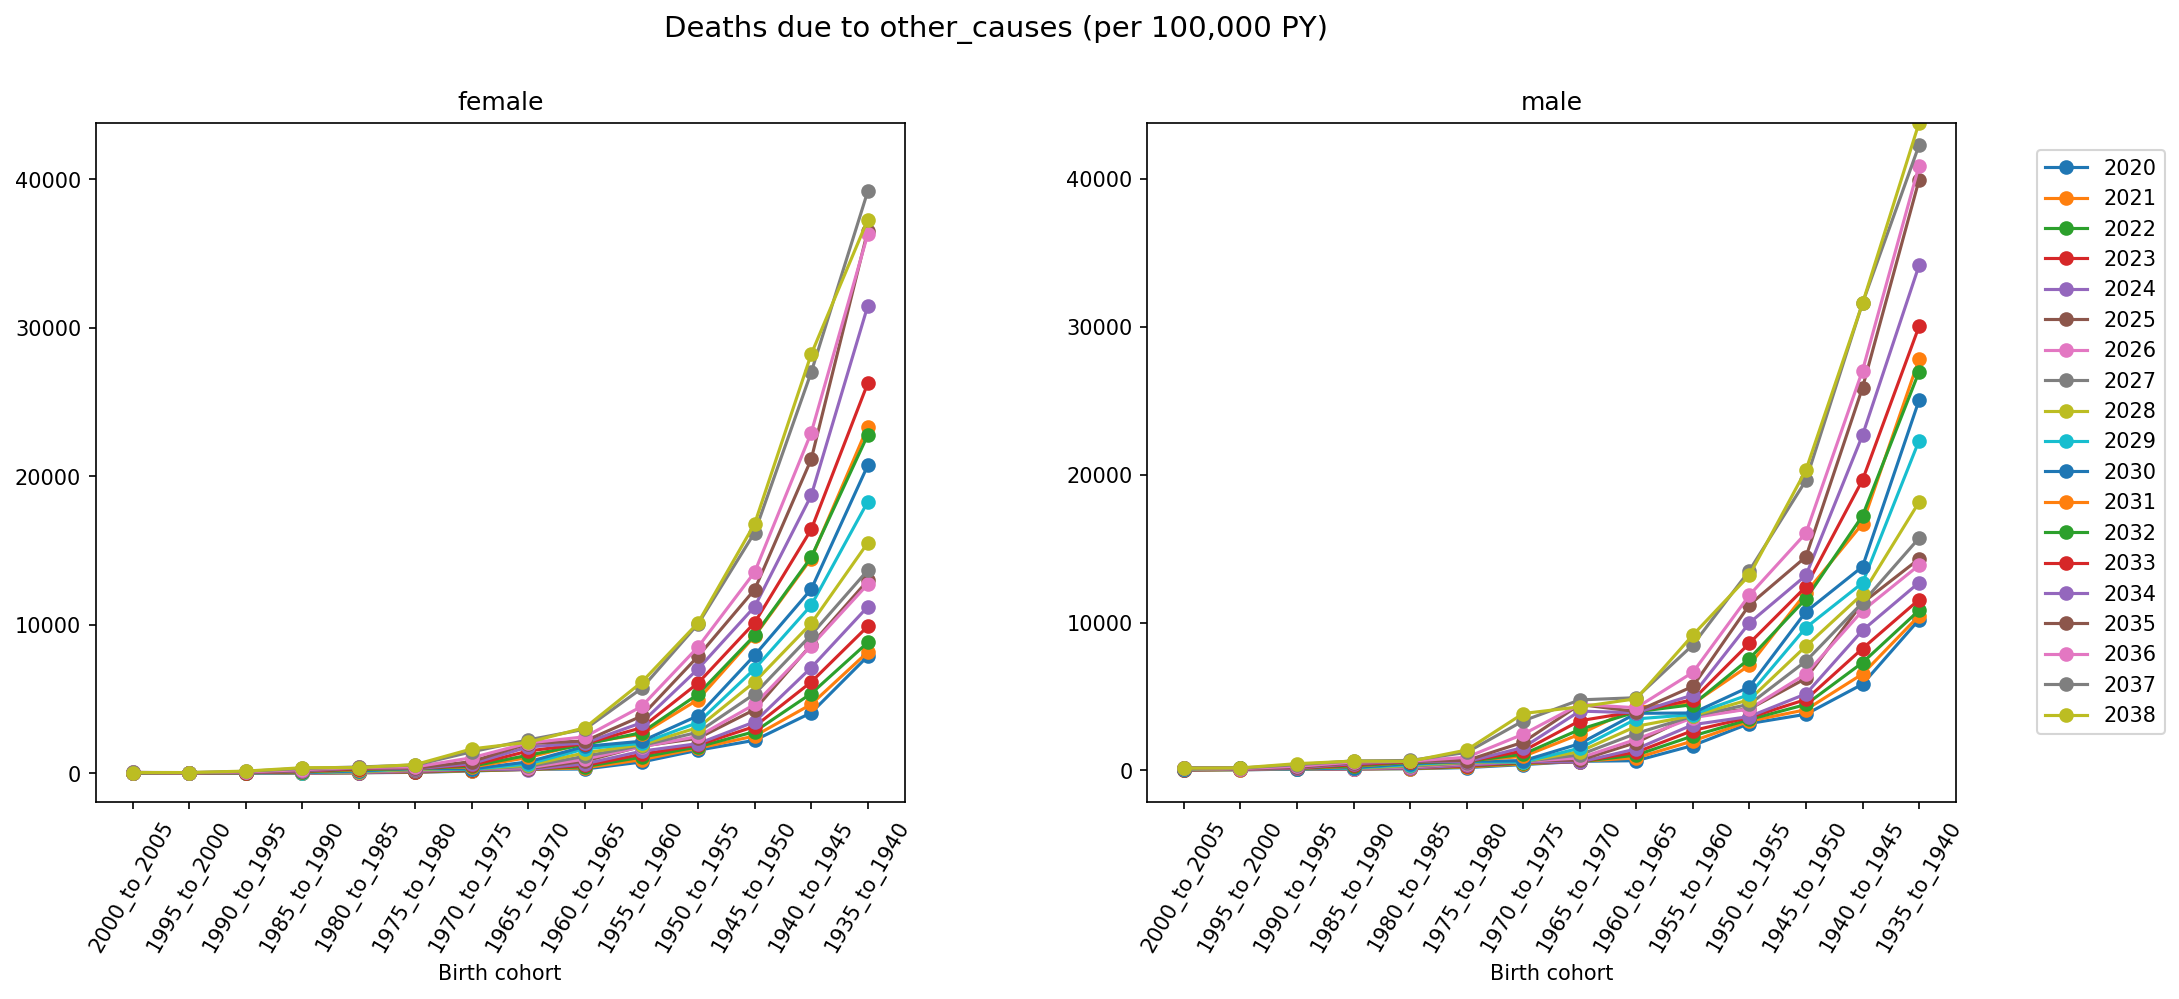

In [14]:
plot_over_age(csmr_summary, 'Deaths', 'cause', 'other_causes')

# Incidence

In [15]:
# breast_cancer_incidence_count = dcis_to_bc_count + lcis_to_bc_count
bc_from_dcis = (df['transition_count']
                .query('measure == "ductal_carcinoma_in_situ_to_breast_cancer_event_count"')
                .drop(columns='measure')
                .set_index([c for c in cols if c not in ['cause', 'measure']]))

bc_from_lcis = (df['transition_count']
                .query('measure == "lobular_carcinoma_in_situ_to_breast_cancer_event_count"')
                .drop(columns='measure')
                .set_index([c for c in cols if c not in ['cause', 'measure']]))

bc_from_bcis = (bc_from_dcis + bc_from_lcis).reset_index()
bc_from_bcis['measure'] = 'breast_carcinoma_in_situ_to_breast_cancer_event_count'

incidence_count = pd.concat([bc_from_bcis, df['transition_count']], ignore_index=True)
incidence_count

age_cohort     sex  year  input_draw  value  \
0       2000_to_2005  female  2020           3    0.0   
1       1995_to_2000  female  2020           3    0.0   
2       1990_to_1995  female  2020           3    9.0   
3       1985_to_1990  female  2020           3   17.0   
...              ...     ...   ...         ...    ...   
132996  1935_to_1940    male  2038         990    0.0   
132997  1935_to_1940    male  2038         990    0.0   
132998  1935_to_1940    male  2038         990    0.0   
132999  1935_to_1940    male  2038         990    0.0   

                                                  measure  
0       breast_carcinoma_in_situ_to_breast_cancer_even...  
1       breast_carcinoma_in_situ_to_breast_cancer_even...  
2       breast_carcinoma_in_situ_to_breast_cancer_even...  
3       breast_carcinoma_in_situ_to_breast_cancer_even...  
...                                                   ...  
132996  susceptible_to_breast_cancer_to_lobular_carcin...  
132997  susceptible_to_breast_cancer_to_ductal_carcino...  
132998  ductal_carcinoma_in_situ_to_breast_cancer_even...  
132999  lobular_carcinoma_in_situ_to_breast_cancer_eve...  

[133000 rows x 6 columns]

In [16]:
incidence_rate = (incidence_count.set_index([c for c in cols if c != 'cause'])
                  .div(df['person_time'].drop(columns='measure').set_index([c for c in cols if c not in ['cause', 'measure']]))
                  .mul(100_000)
                  .reset_index())

incidence_rate_summary = (incidence_rate
                          .groupby([c for c in cols if c not in ['input_draw', 'cause']])
                          .value.describe(percentiles=[.025, .975])
                          .filter(['mean', '2.5%', '97.5%'])
                          .reset_index())
incidence_rate_summary

age_cohort     sex  year  \
0     1935_to_1940  female  2020   
1     1935_to_1940  female  2020   
2     1935_to_1940  female  2020   
3     1935_to_1940  female  2020   
...            ...     ...   ...   
2656  2000_to_2005    male  2038   
2657  2000_to_2005    male  2038   
2658  2000_to_2005    male  2038   
2659  2000_to_2005    male  2038   

                                                measure       mean      2.5%  \
0     breast_carcinoma_in_situ_to_breast_cancer_even...  80.680406  7.563239   
1     ductal_carcinoma_in_situ_to_breast_cancer_even...  66.989679  0.000000   
2     lobular_carcinoma_in_situ_to_breast_cancer_eve...  13.690728  0.000000   
3     susceptible_to_breast_cancer_to_ductal_carcino...  35.194104  0.000000   
...                                                 ...        ...       ...   
2656  ductal_carcinoma_in_situ_to_breast_cancer_even...   0.118617  0.000000   
2657  lobular_carcinoma_in_situ_to_breast_cancer_eve...   0.000000  0.000000   
2658  susceptible_to_breast_cancer_to_ductal_carcino...   0.159235  0.000000   
2659  susceptible_to_breast_cancer_to_lobular_carcin...   0.000000  0.000000   

           97.5%  
0     167.957635  
1     149.660089  
2      64.809308  
3     101.566587  
...          ...  
2656    0.992816  
2657    0.000000  
2658    1.012969  
2659    0.000000  

[2660 rows x 7 columns]

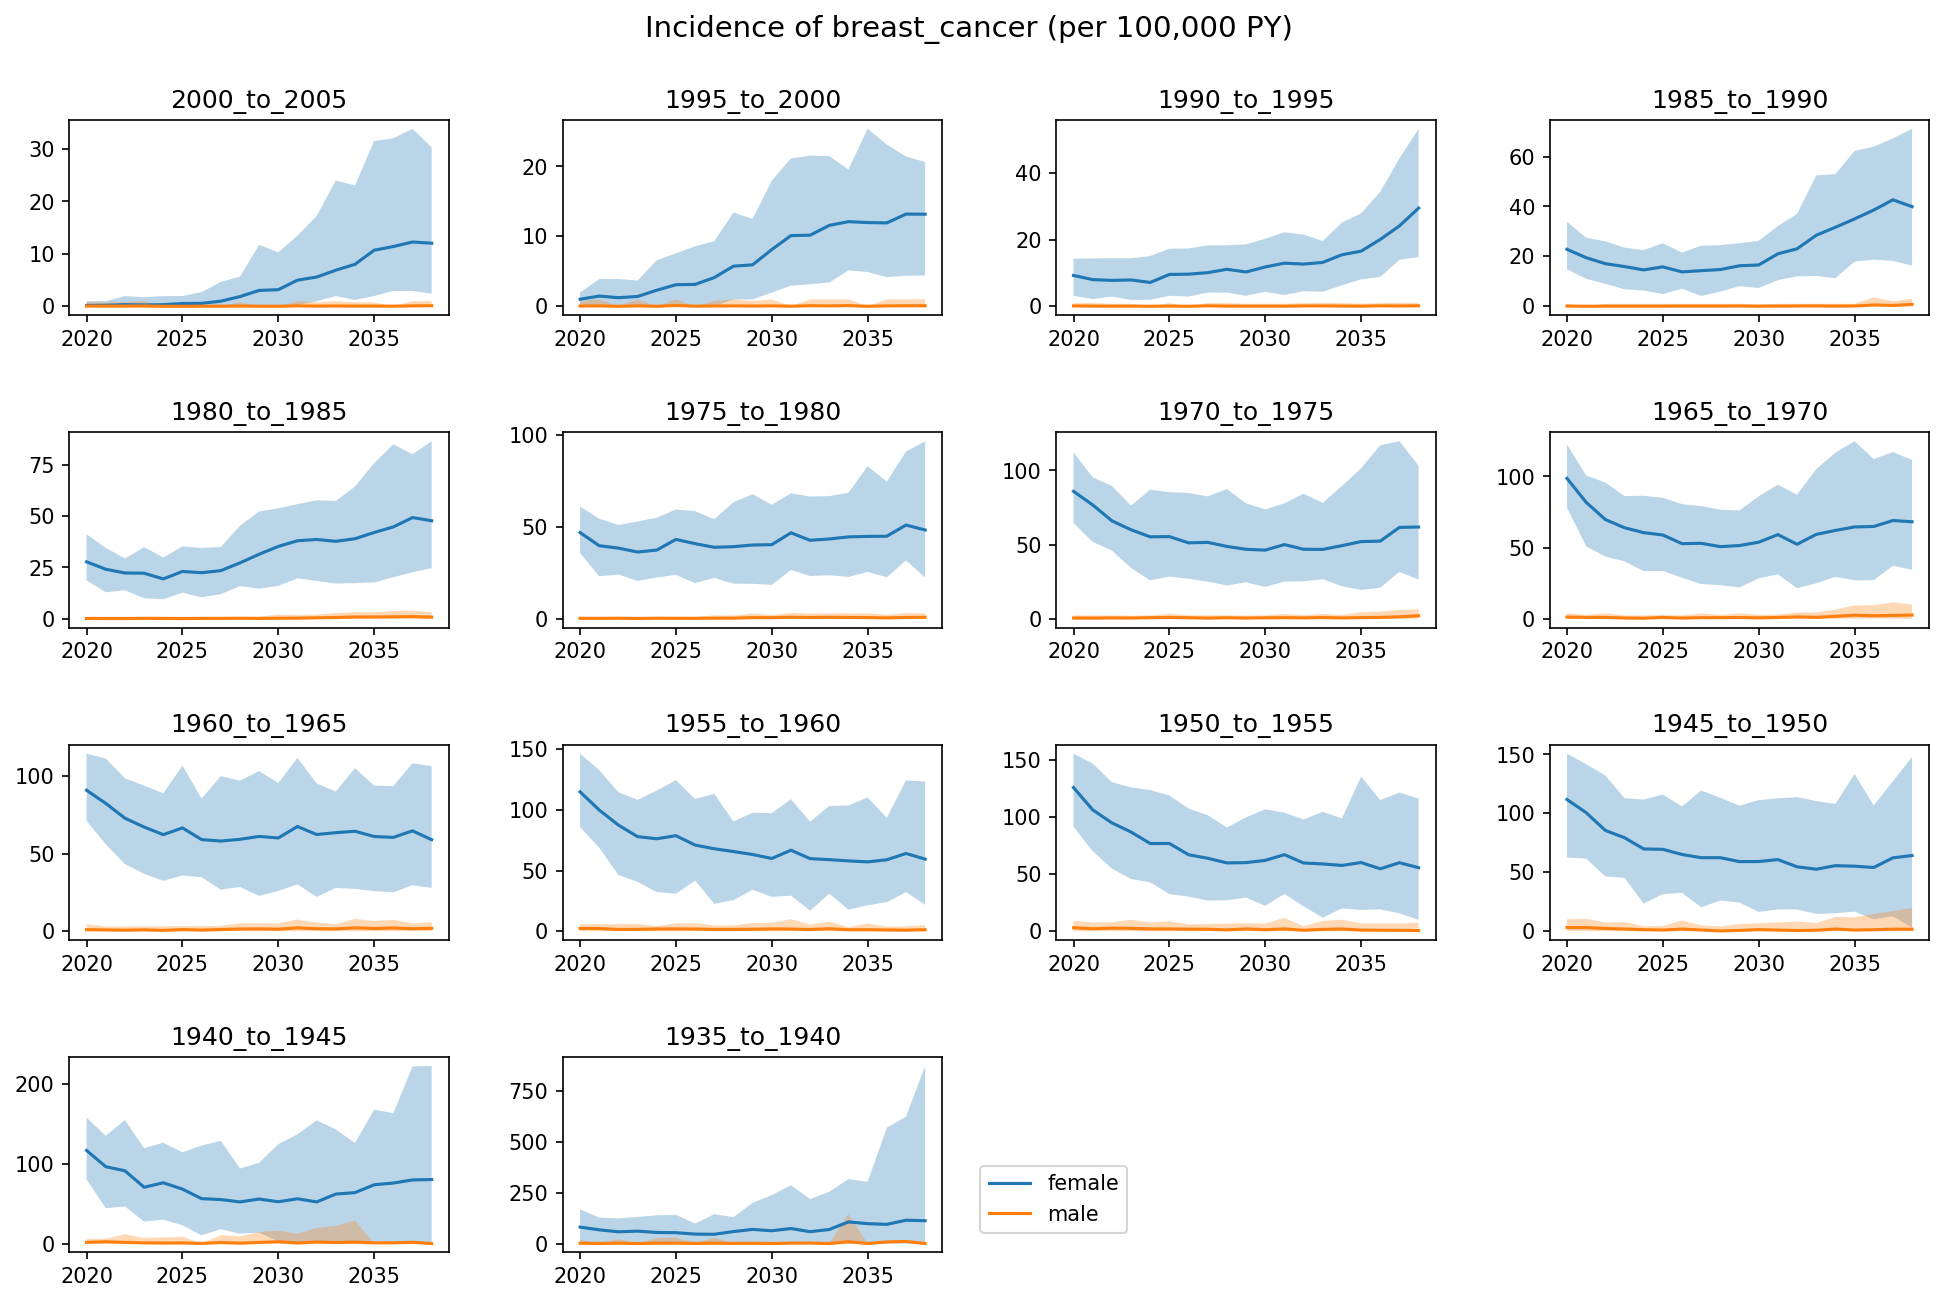

In [17]:
plot_over_year(incidence_rate_summary, 'Incidence', 'measure', 
               'breast_carcinoma_in_situ_to_breast_cancer_event_count')

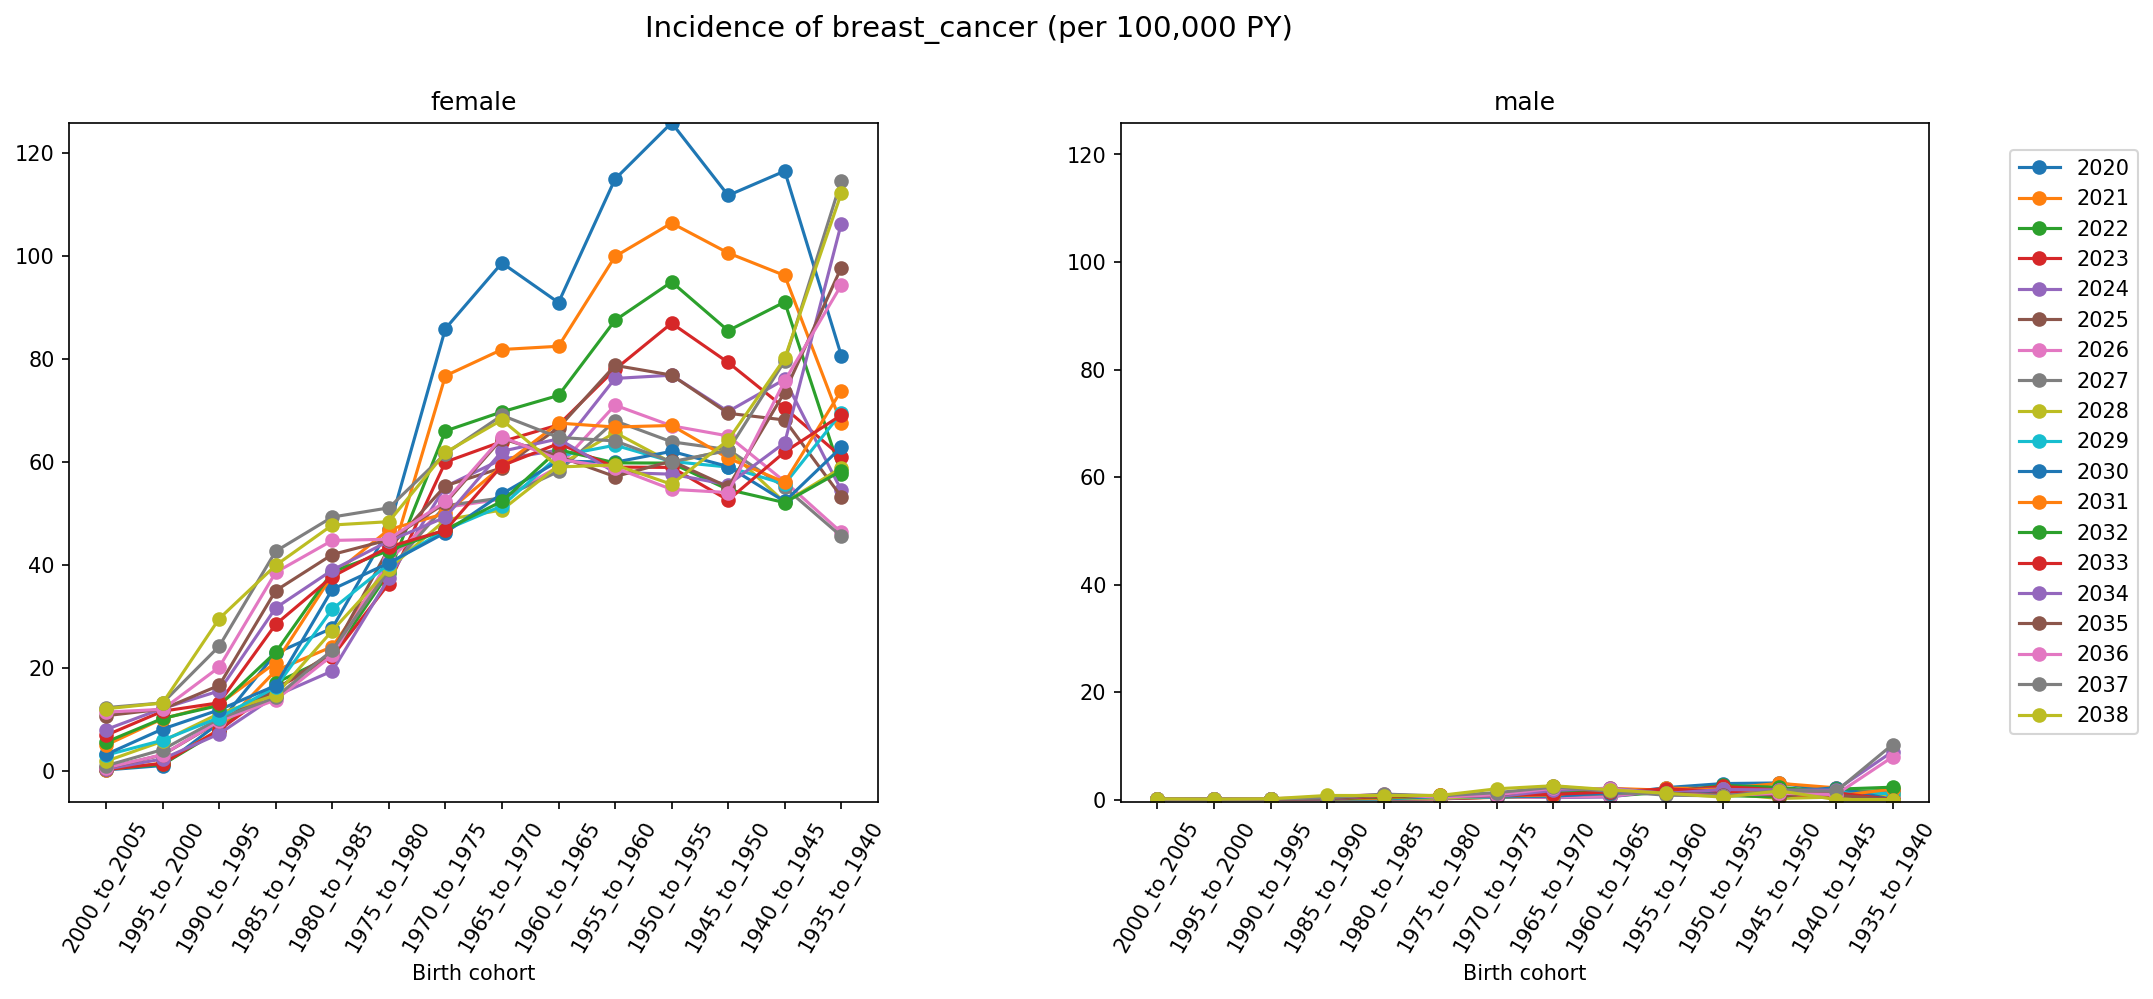

In [18]:
plot_over_age(incidence_rate_summary, 'Incidence', 'measure', 
              'breast_carcinoma_in_situ_to_breast_cancer_event_count')

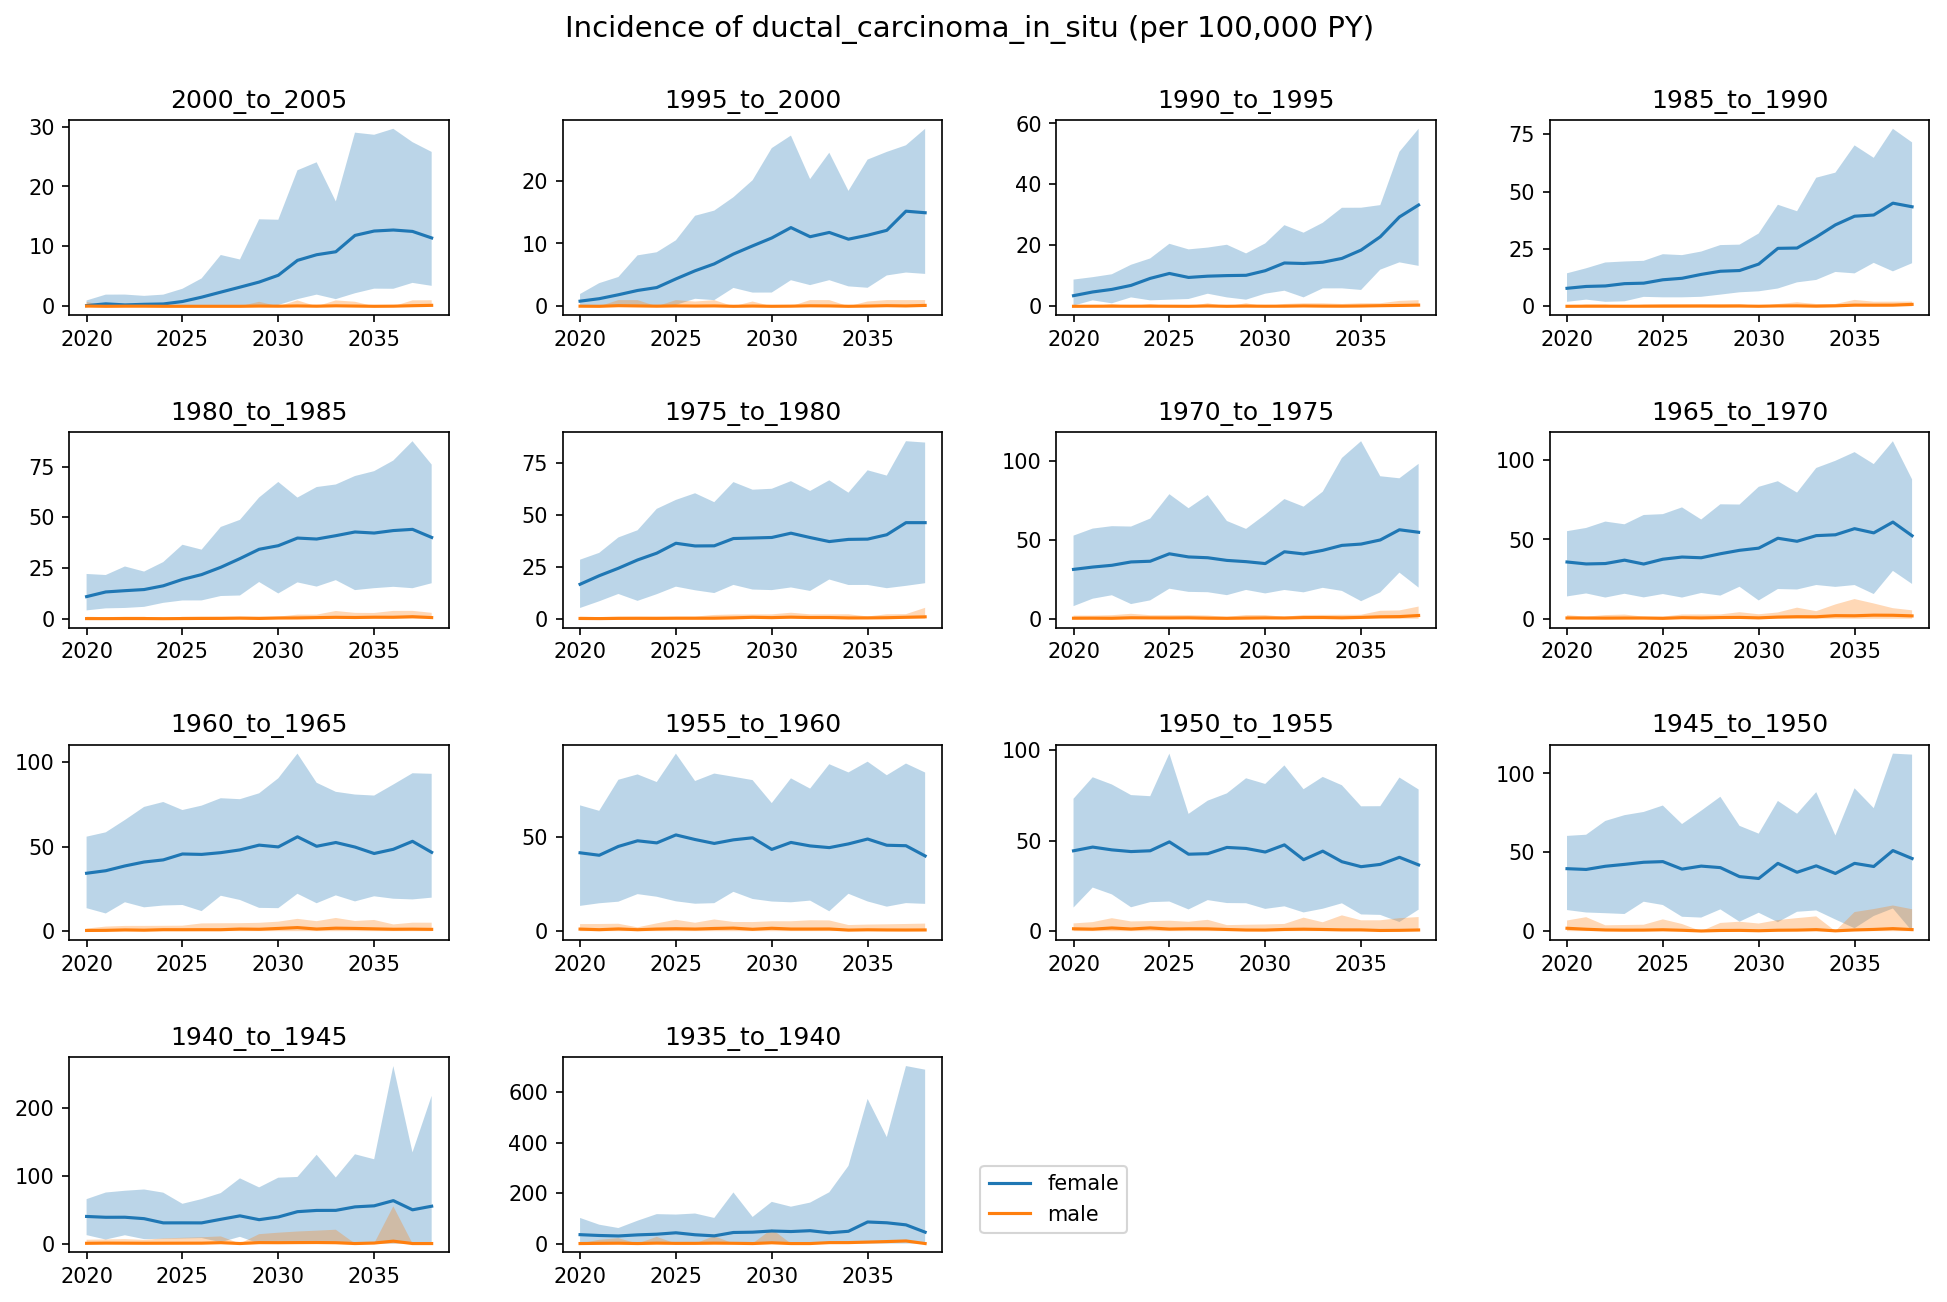

In [19]:
plot_over_year(incidence_rate_summary, 'Incidence', 'measure', 
               'susceptible_to_breast_cancer_to_ductal_carcinoma_in_situ_event_count')

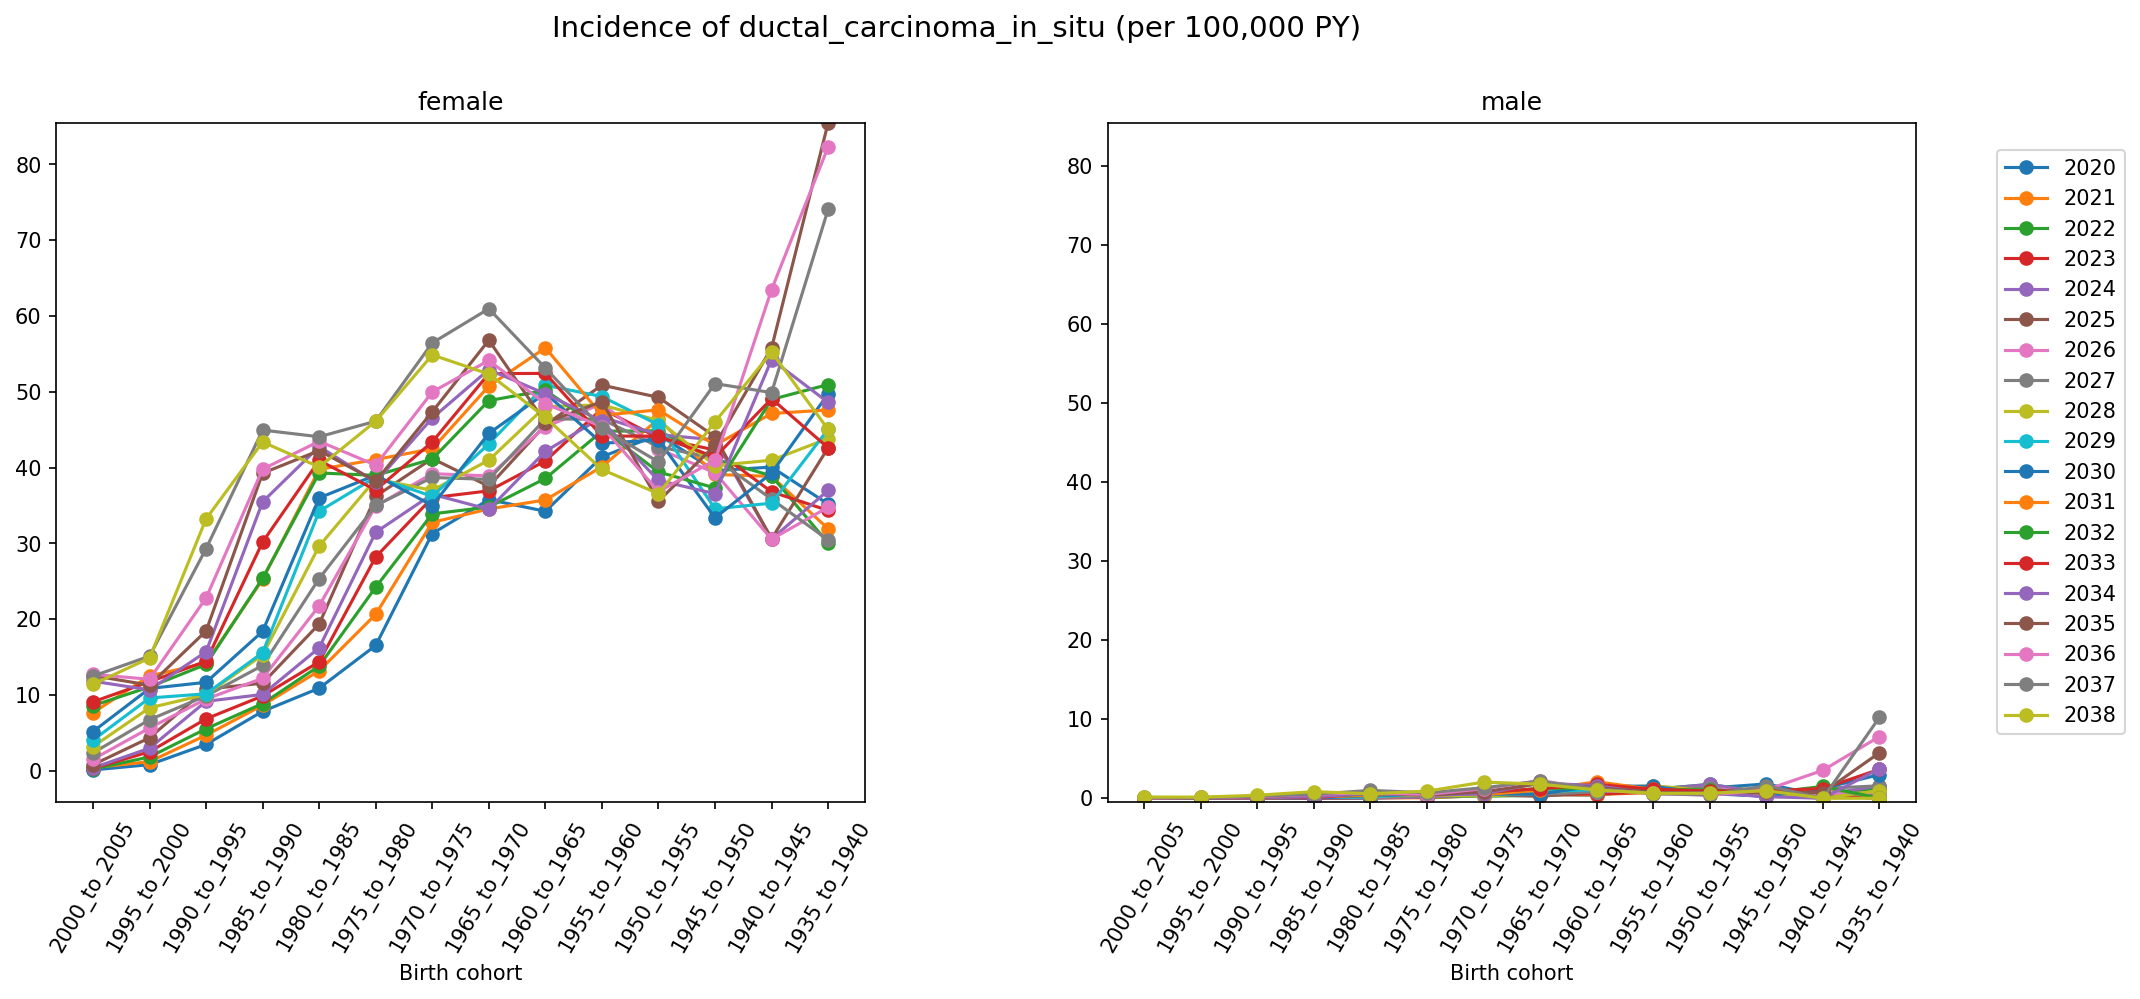

In [20]:
plot_over_age(incidence_rate_summary, 'Incidence', 'measure', 
              'susceptible_to_breast_cancer_to_ductal_carcinoma_in_situ_event_count')

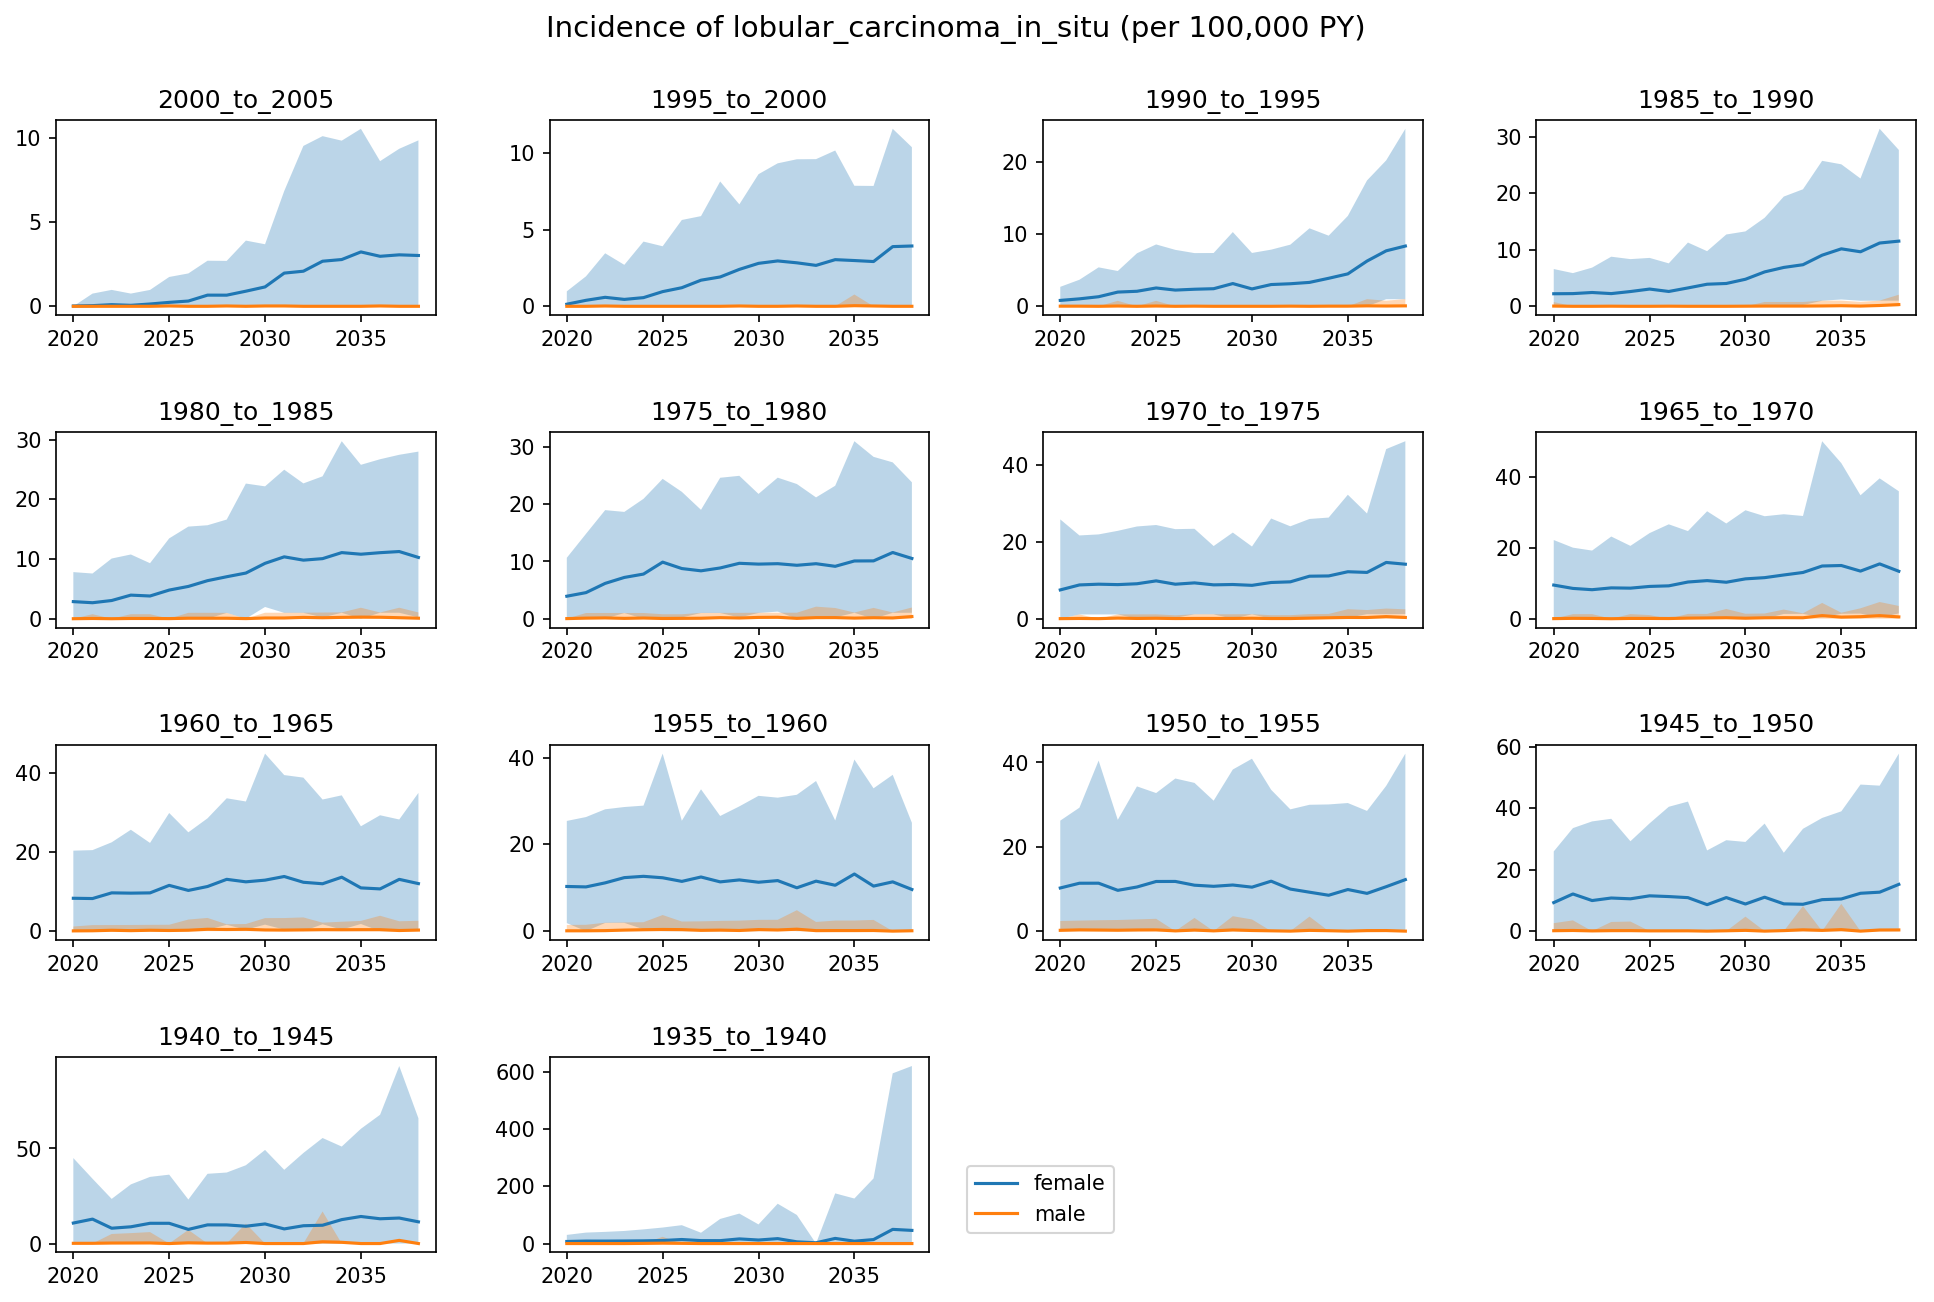

In [21]:
plot_over_year(incidence_rate_summary, 'Incidence', 'measure', 
               'susceptible_to_breast_cancer_to_lobular_carcinoma_in_situ_event_count')

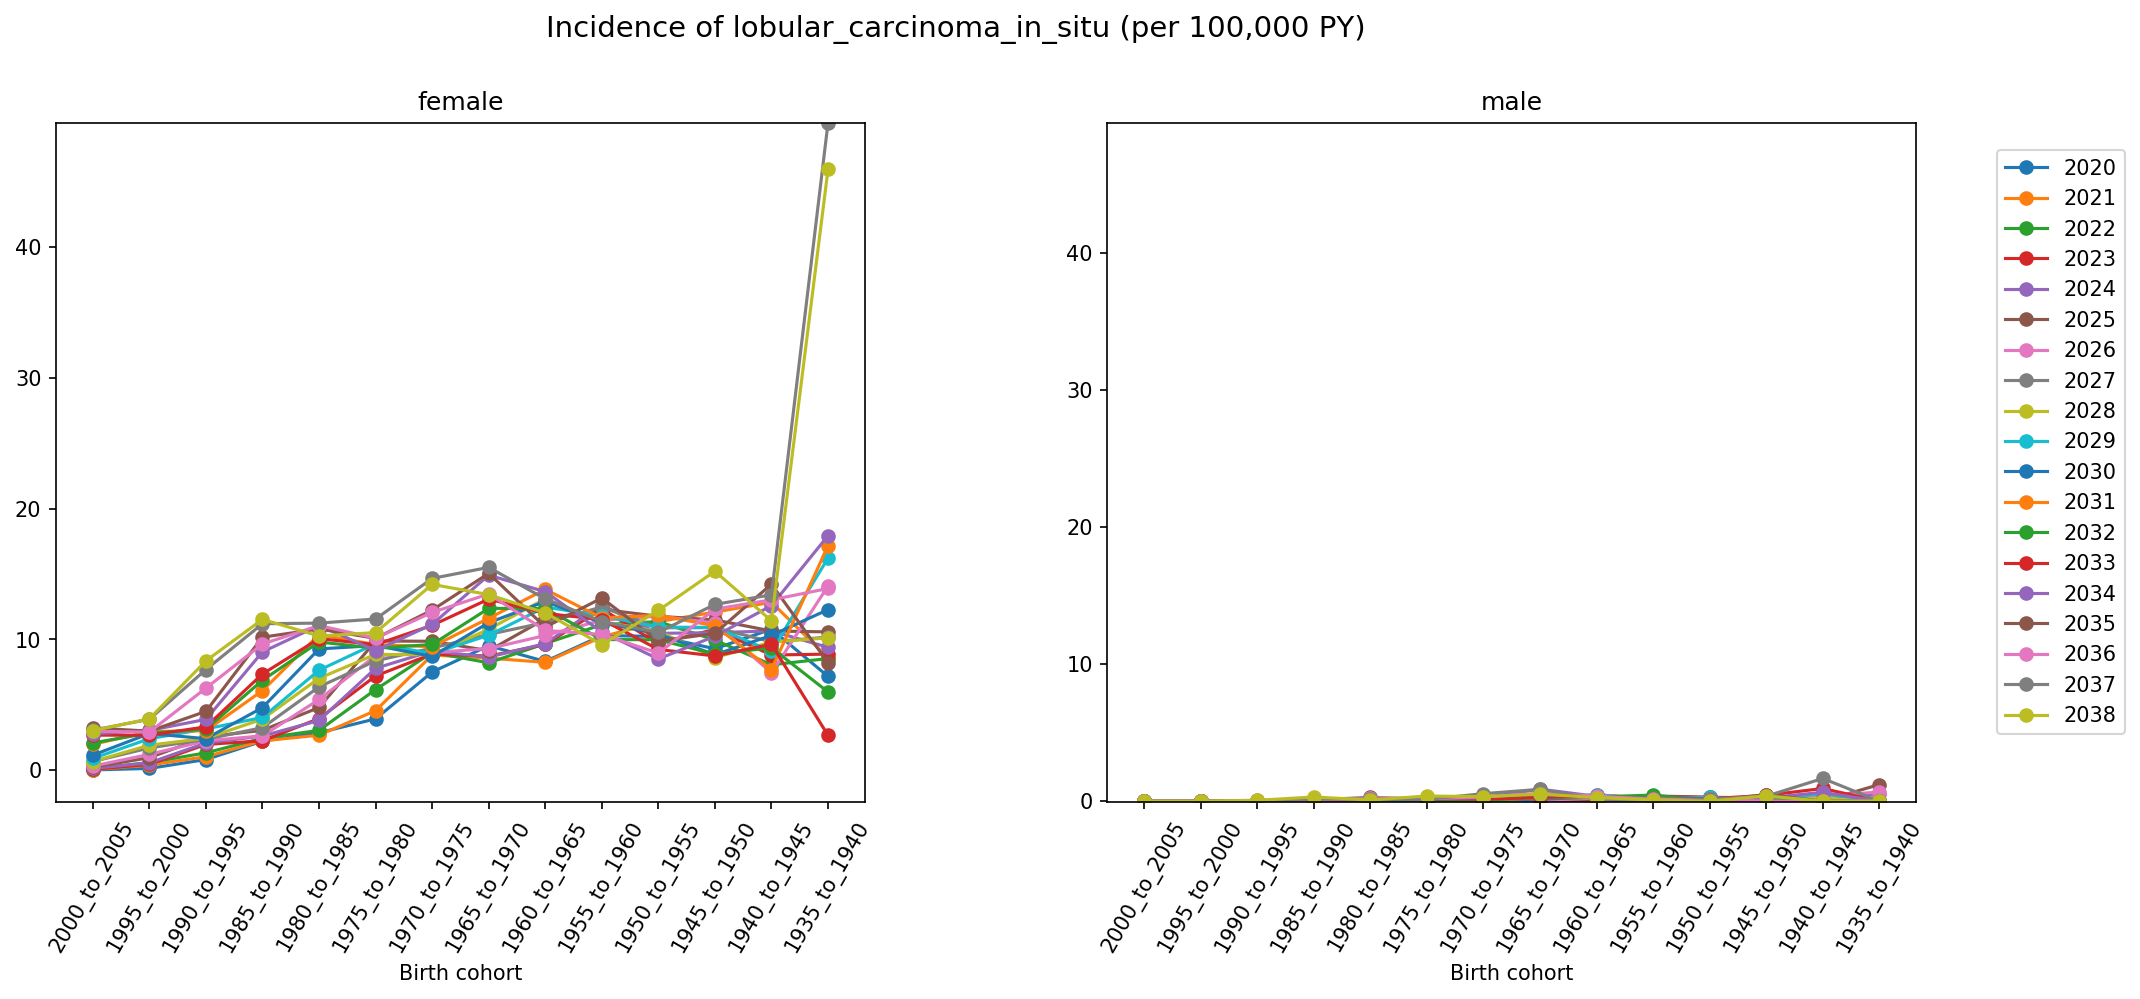

In [22]:
plot_over_age(incidence_rate_summary, 'Incidence', 'measure', 
              'susceptible_to_breast_cancer_to_lobular_carcinoma_in_situ_event_count')

# Prevalence

In [23]:
state_person_time = df['state_person_time'].loc[
    df['state_person_time'].cause.isin(['breast_cancer', 'ductal_carcinoma_in_situ', 'lobular_carcinoma_in_situ'])
]

prevalence = (state_person_time.drop(columns='measure').set_index([c for c in cols if c != 'measure'])
              .div(df['person_time'].drop(columns='measure').set_index([c for c in cols if c not in ['cause', 'measure']]))
              .mul(100)
              .reset_index())

prevalence_summary = (prevalence
                      .groupby([c for c in cols if c not in ['input_draw', 'measure']])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
prevalence_summary

age_cohort     sex  year                      cause      mean  \
0     1935_to_1940  female  2020              breast_cancer  0.734934   
1     1935_to_1940  female  2020   ductal_carcinoma_in_situ  0.220959   
2     1935_to_1940  female  2020  lobular_carcinoma_in_situ  0.049096   
3     1935_to_1940  female  2021              breast_cancer  0.693544   
...            ...     ...   ...                        ...       ...   
1592  2000_to_2005    male  2037  lobular_carcinoma_in_situ  0.000029   
1593  2000_to_2005    male  2038              breast_cancer  0.000914   
1594  2000_to_2005    male  2038   ductal_carcinoma_in_situ  0.000138   
1595  2000_to_2005    male  2038  lobular_carcinoma_in_situ  0.000019   

          2.5%     97.5%  
0     0.517334  0.942975  
1     0.060116  0.372507  
2     0.000000  0.138504  
3     0.501025  0.909905  
...        ...       ...  
1592  0.000000  0.000315  
1593  0.000000  0.002717  
1594  0.000000  0.000974  
1595  0.000000  0.000000  

[1596 rows x 7 columns]

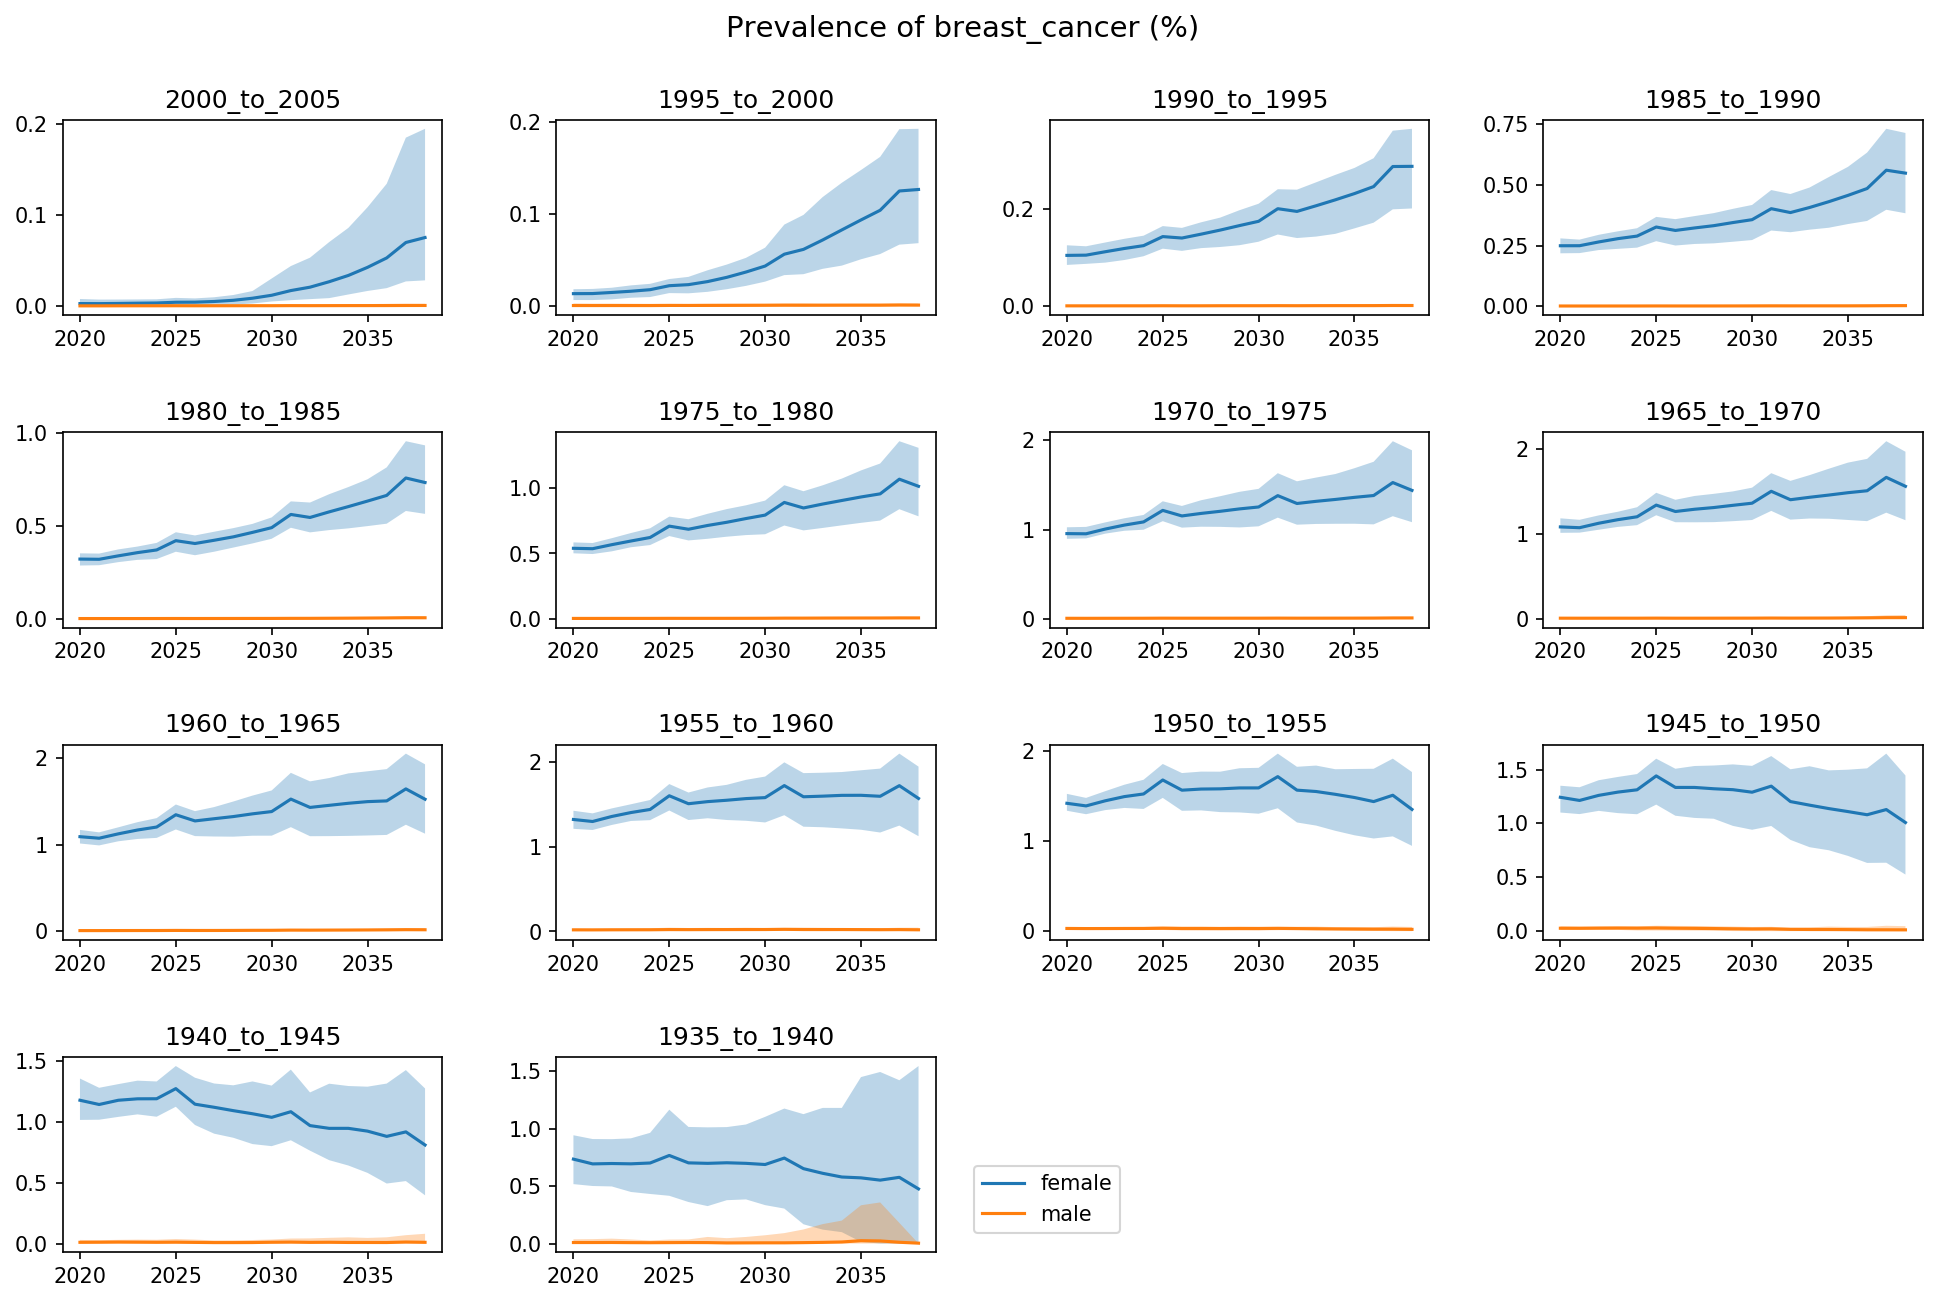

In [24]:
plot_over_year(prevalence_summary, 'Prevalence', 'cause', 'breast_cancer')

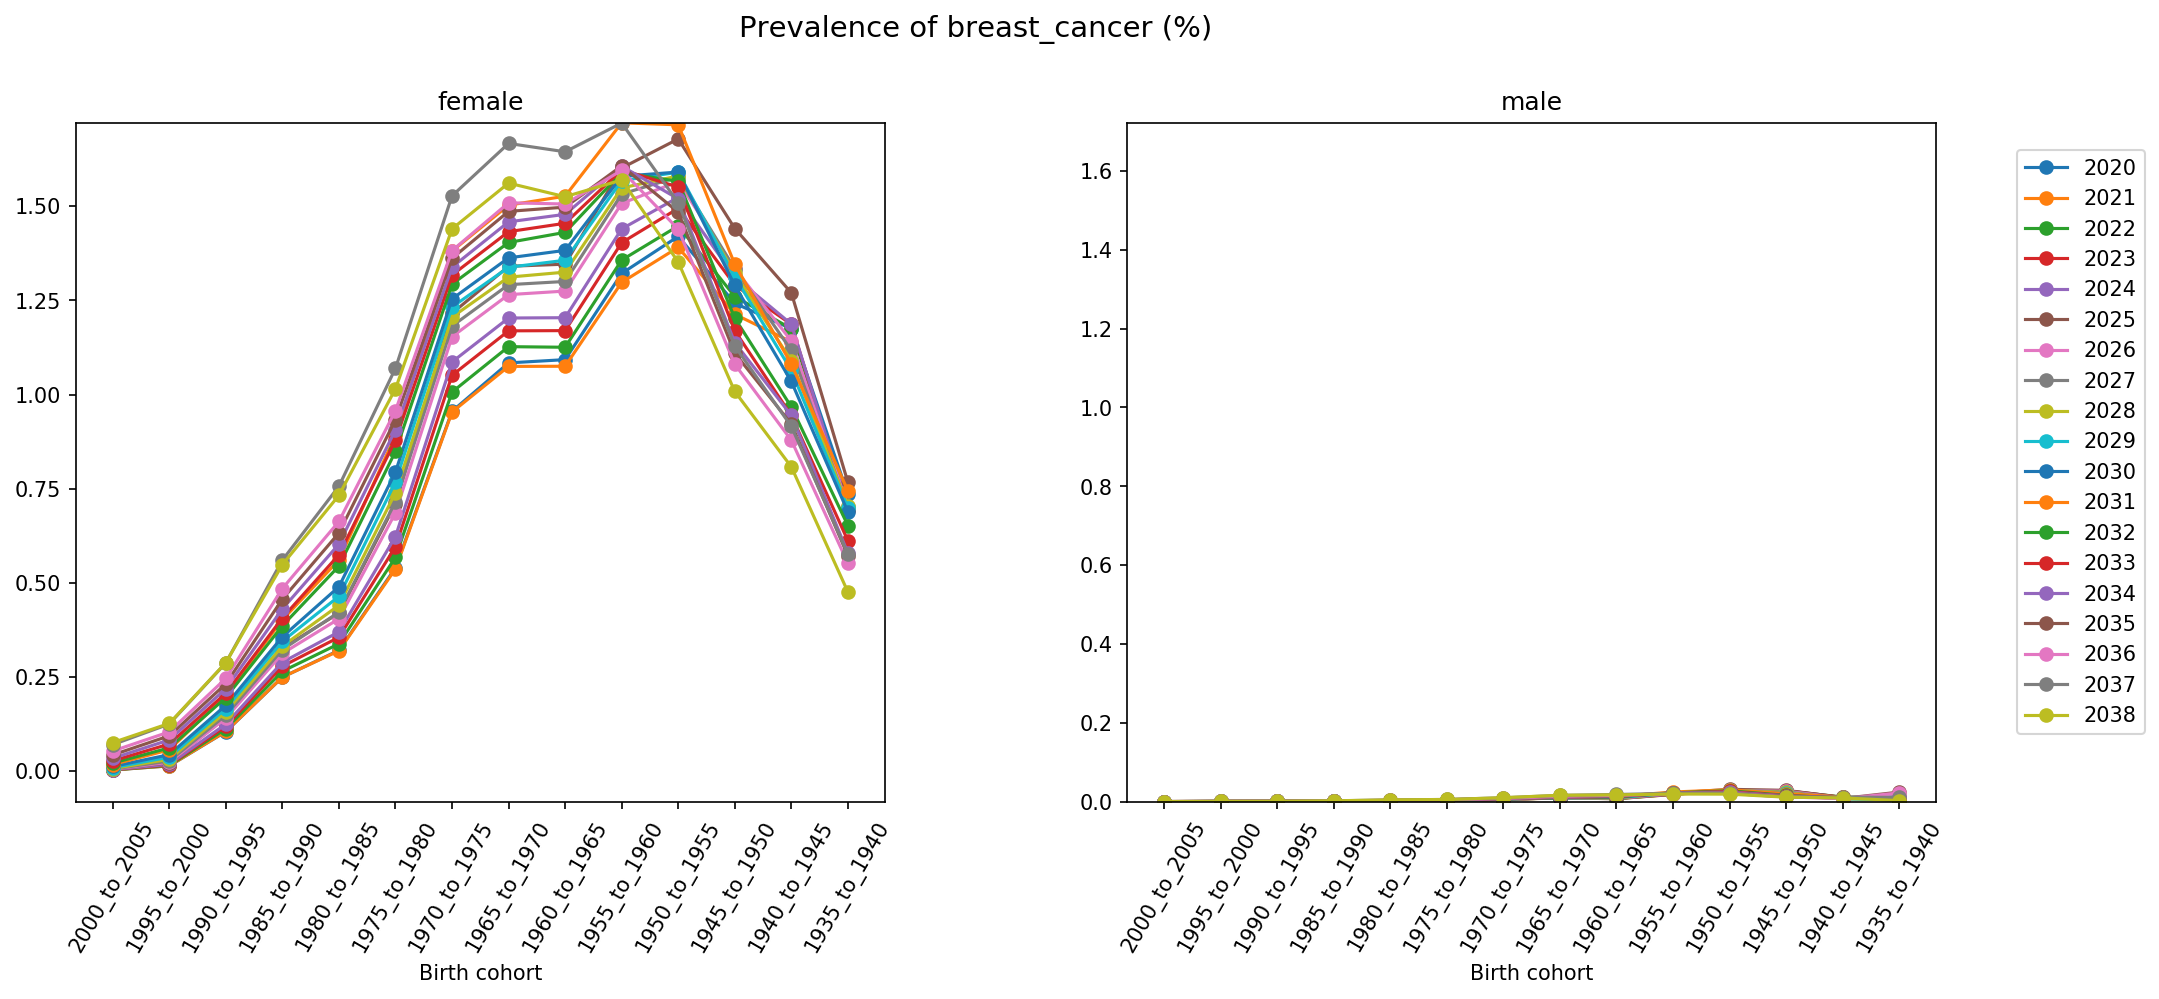

In [25]:
plot_over_age(prevalence_summary, 'Prevalence', 'cause', 'breast_cancer')

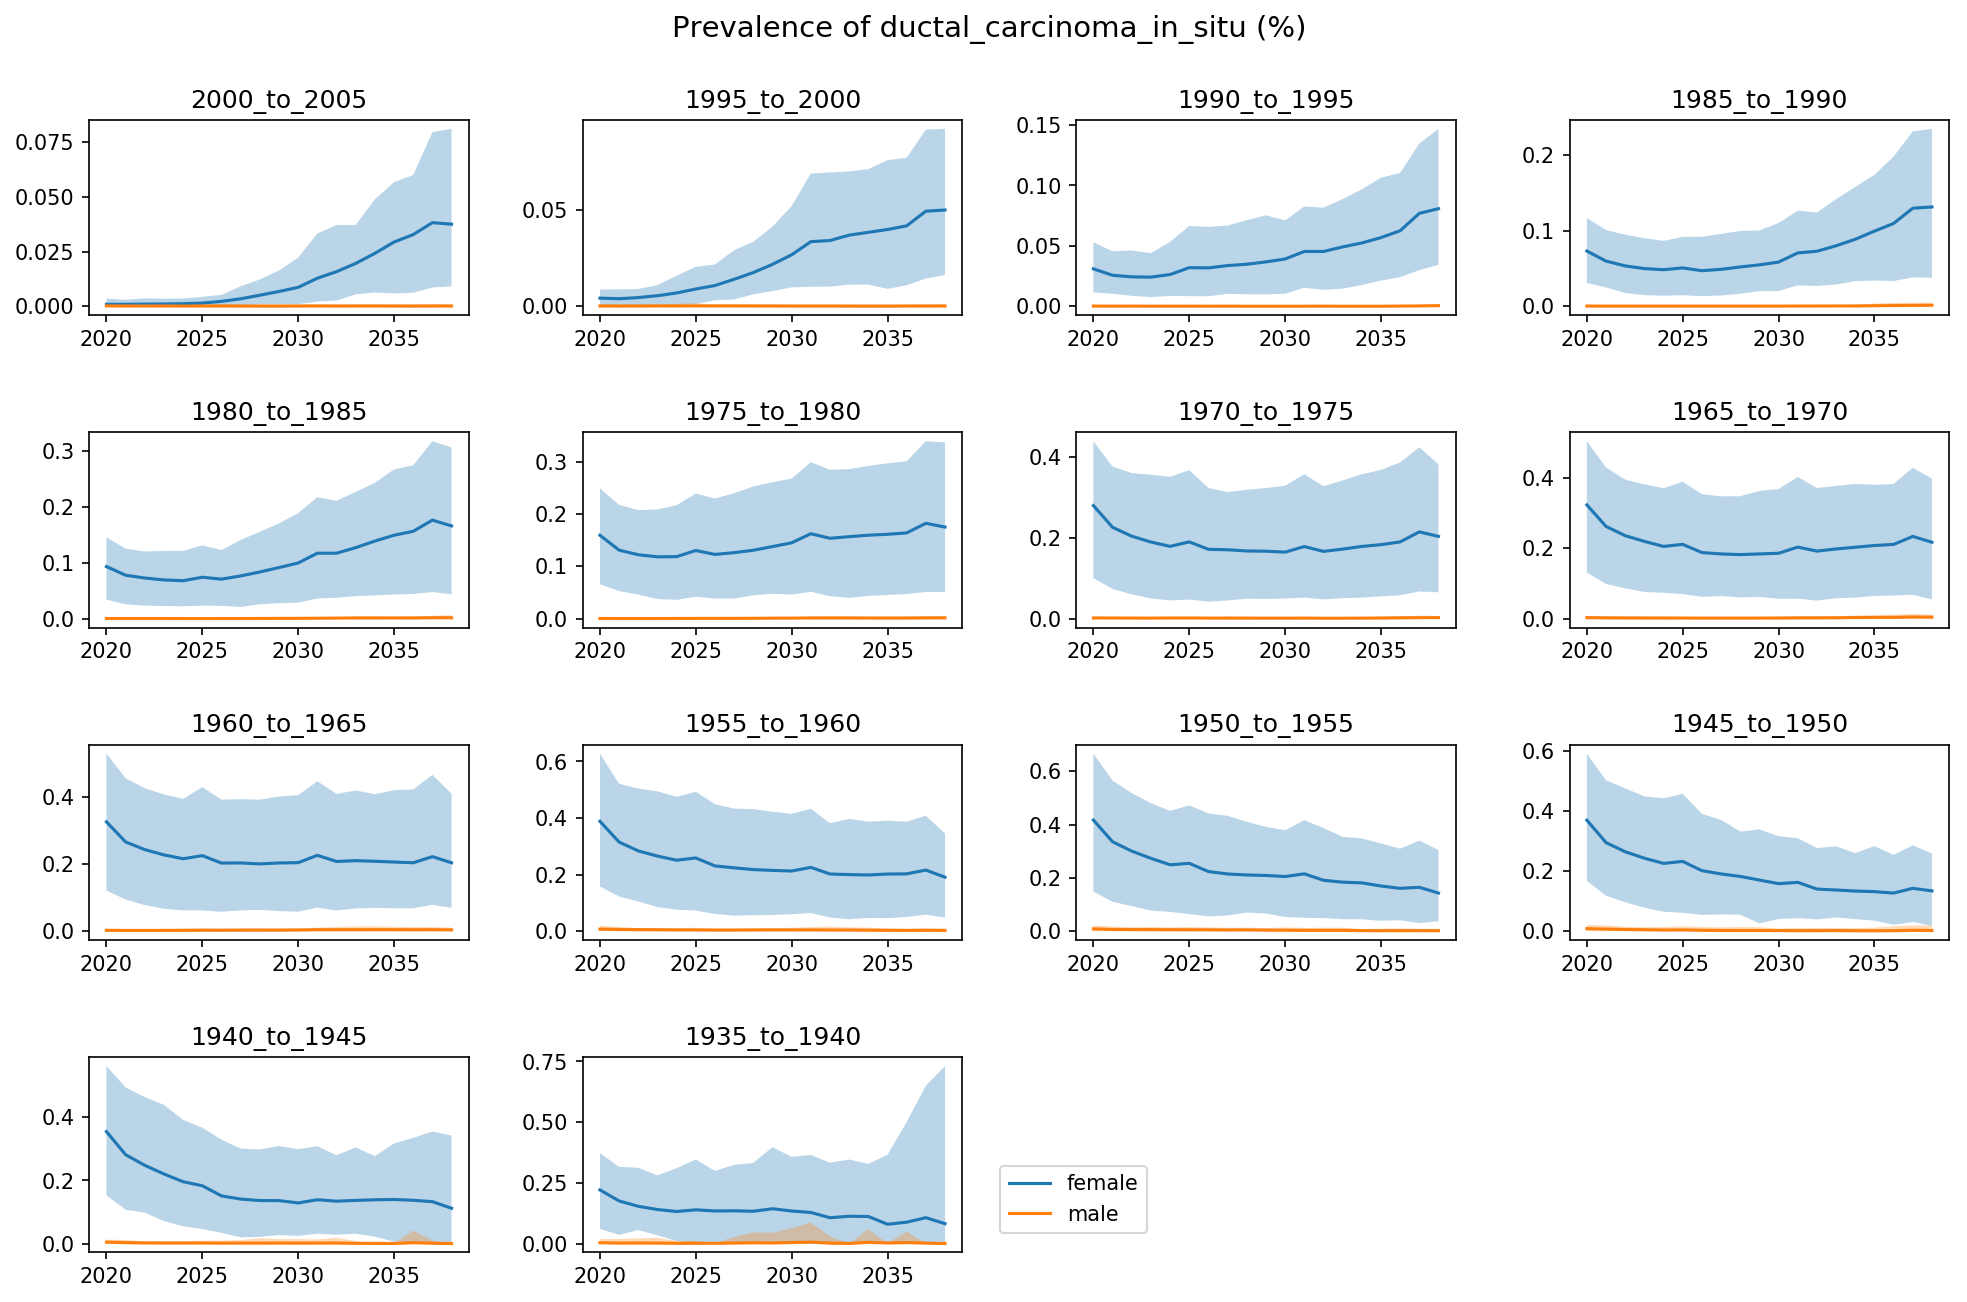

In [26]:
plot_over_year(prevalence_summary, 'Prevalence', 'cause', 'ductal_carcinoma_in_situ')

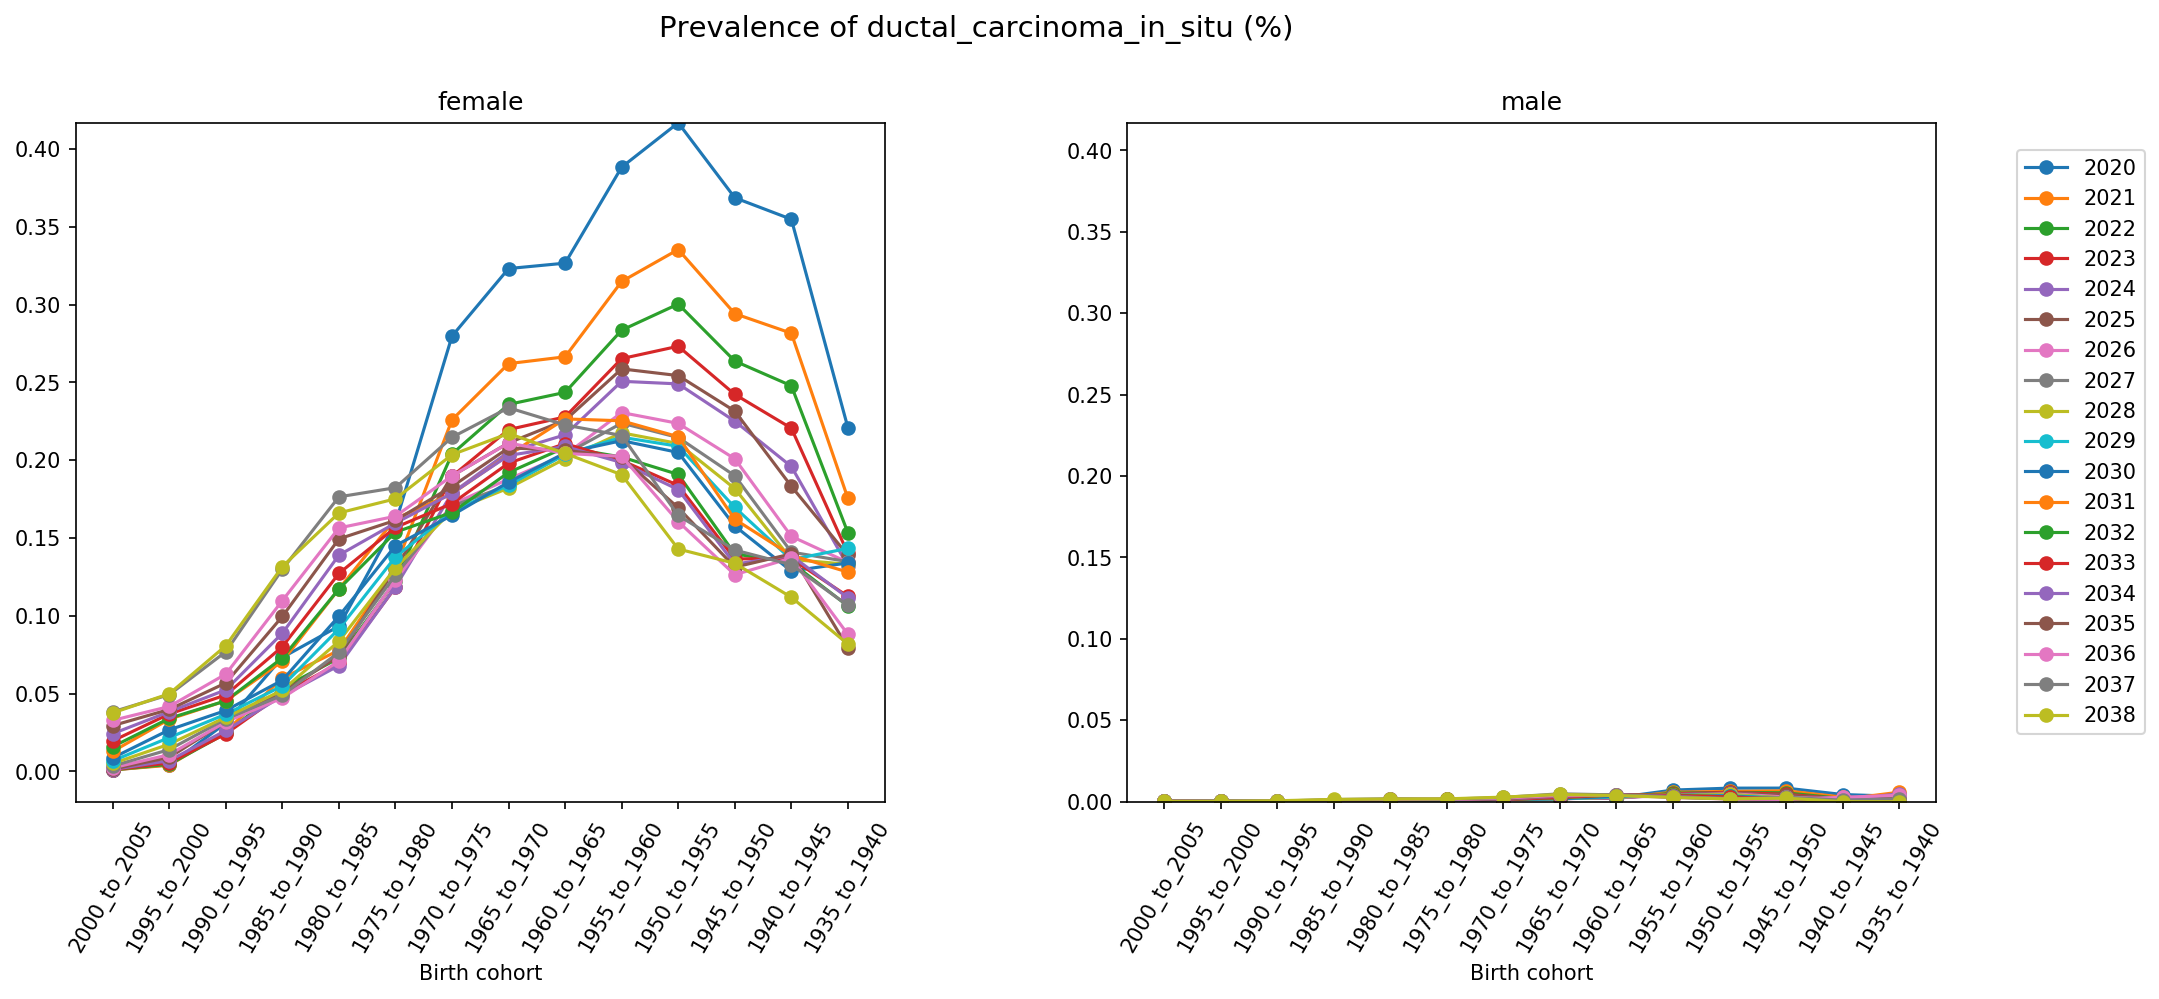

In [27]:
plot_over_age(prevalence_summary, 'Prevalence', 'cause', 'ductal_carcinoma_in_situ')

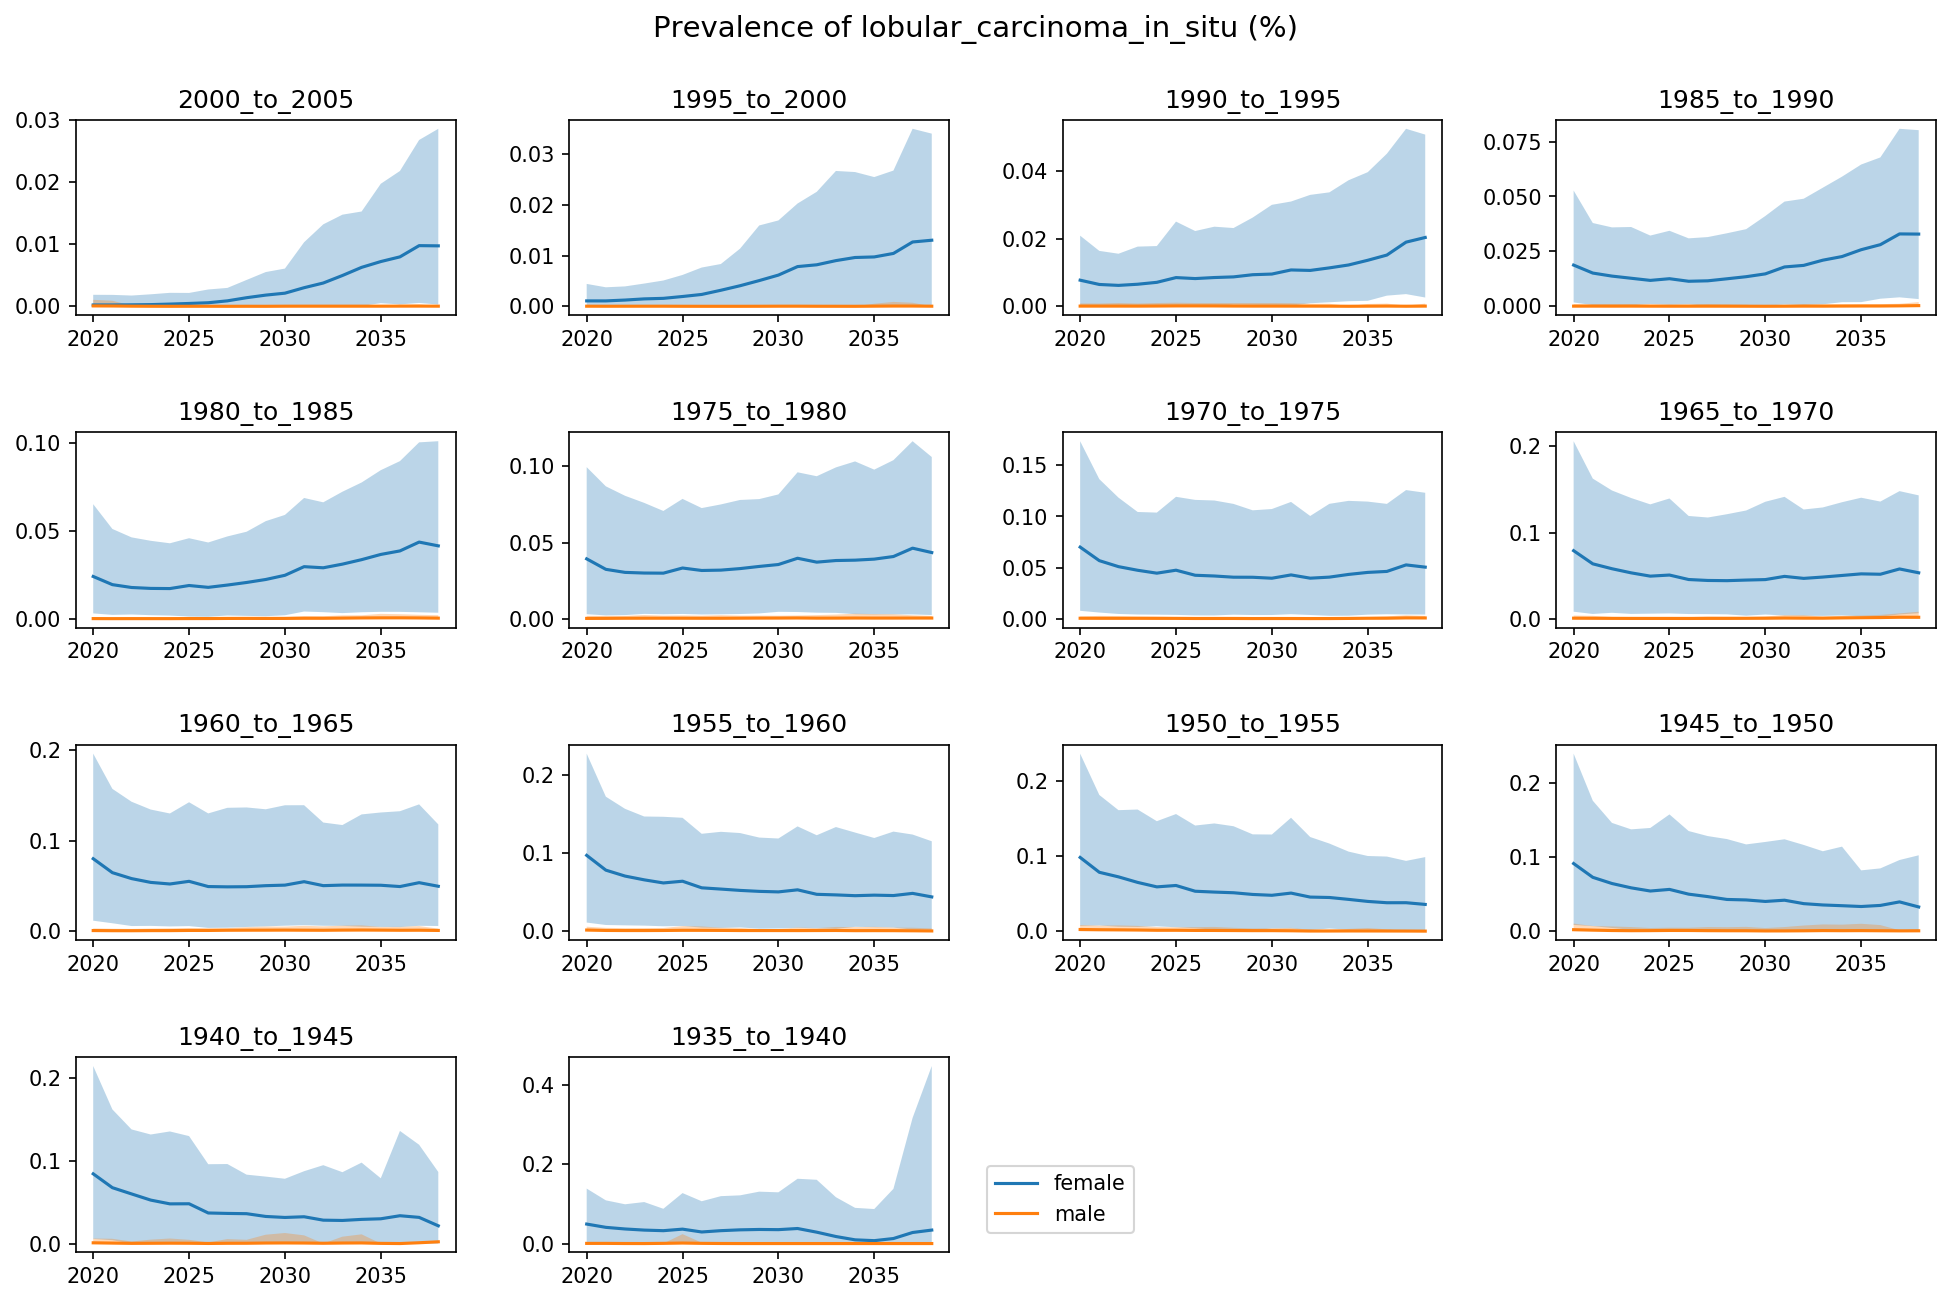

In [28]:
plot_over_year(prevalence_summary, 'Prevalence', 'cause', 'lobular_carcinoma_in_situ')

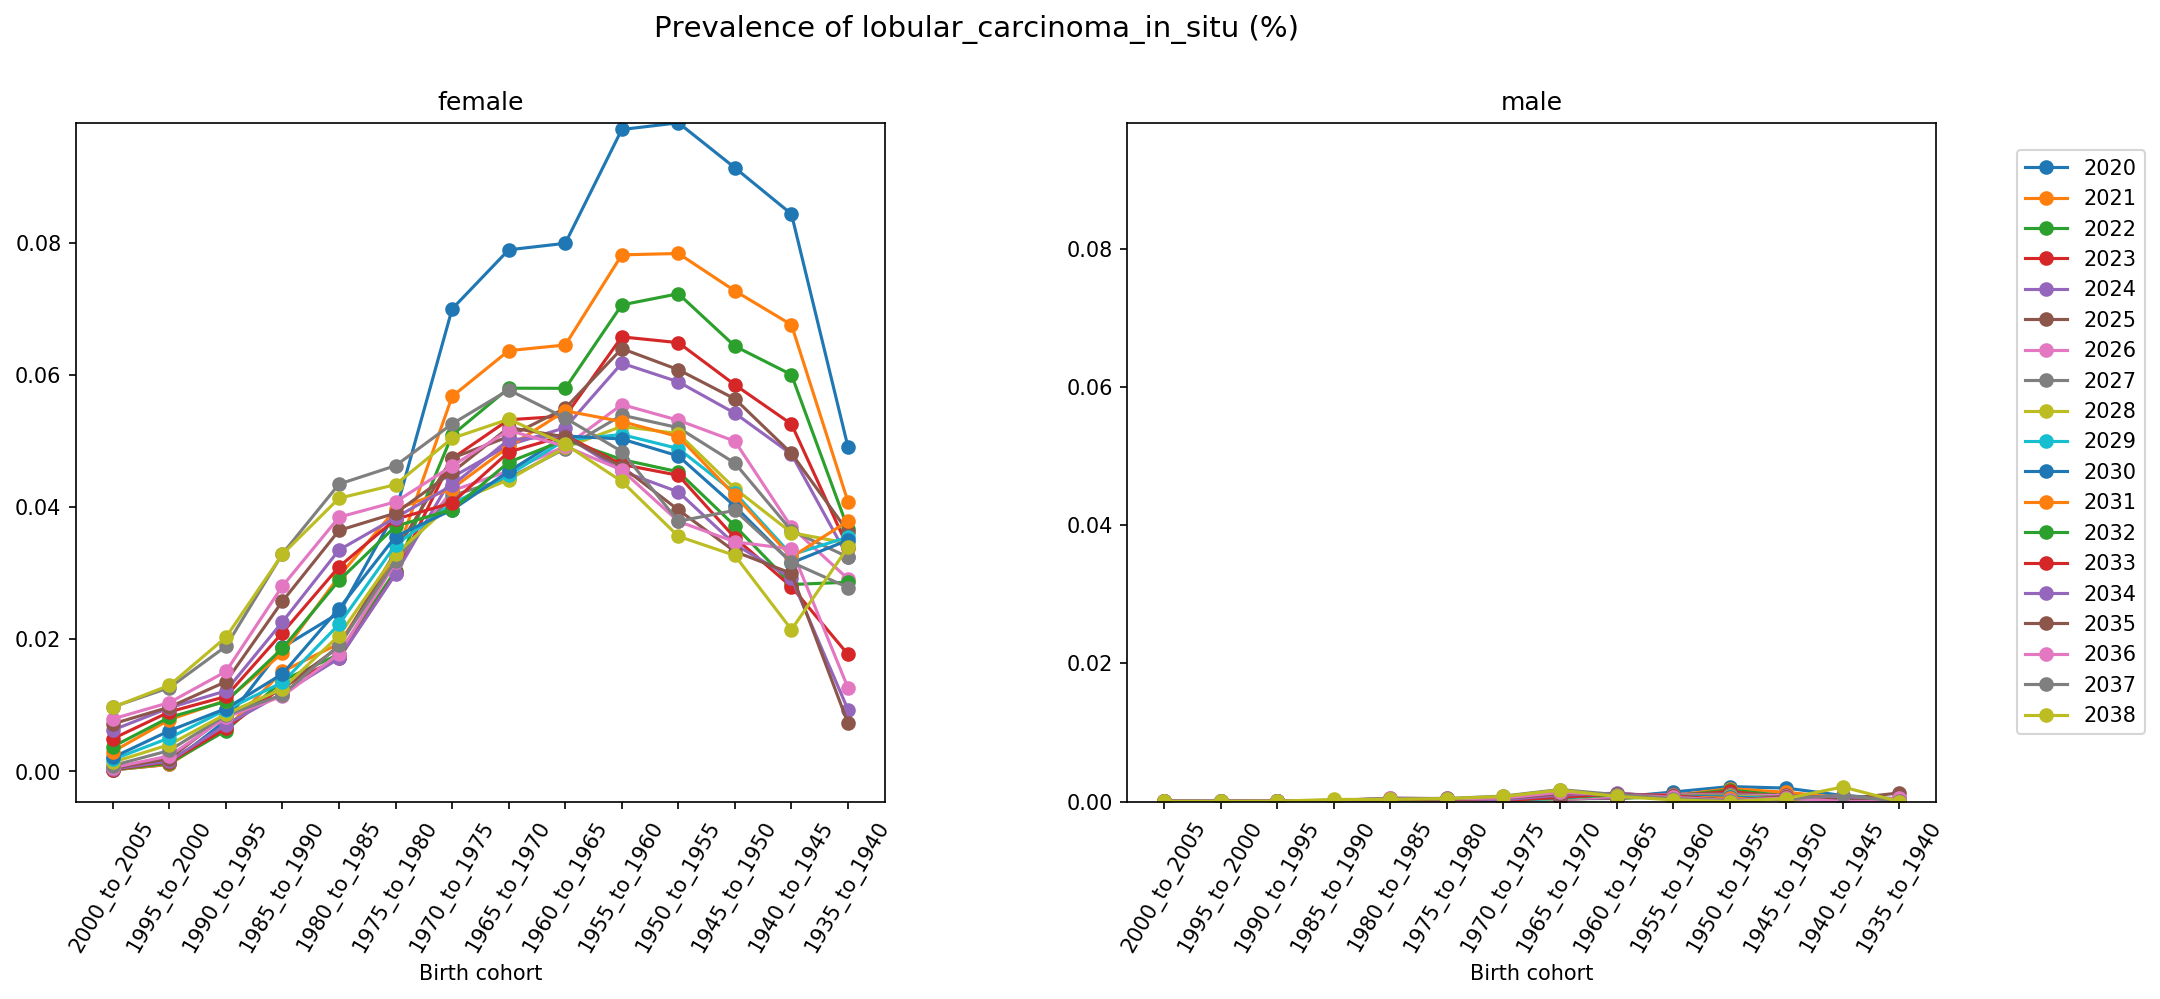

In [29]:
plot_over_age(prevalence_summary, 'Prevalence', 'cause', 'lobular_carcinoma_in_situ')

# Forecast data

In [30]:
# change the working directory to transformed forecast data
%cd C:/Users/yongqx2/Desktop/Sim Science/Swiss RE Cancer/forecasts
#%cd /ihme/costeffectiveness/vivarium_csu_cancer

C:\Users\yongqx2\Desktop\Sim Science\Swiss RE Cancer\forecasts


In [31]:
forecast_names = glob.glob('*forecast*.csv')
forecast = {}
for forecast_name in forecast_names:
    forecast[forecast_name[:-4]] = (pd.read_csv(forecast_name)
                                 .drop(columns=['location', 'age_group_id', 'sex_id'])
                                 .rename(columns={'year_id': 'year'}))

In [32]:
forecast.keys()

dict_keys(['acmr_forecast', 'c429_csmr_forecast', 'c429_incidence_forecast', 'c429_prev_forecast'])

In [33]:
# note that i manually renamed '2.5%' and '97.5%' to 'lb' and 'ub' in original csv files
forecast['c429_prev_forecast'][['mean', 'lb', 'ub']] *= 100

In [34]:
age_names = {
    '2000_to_2005': '15 to 19',
    '1995_to_2000': '20 to 24',
    '1990_to_1995': '25 to 29',
    '1985_to_1990': '30 to 34',
    '1980_to_1985': '35 to 39',
    '1975_to_1980': '40 to 44',
    '1970_to_1975': '45 to 49',
    '1965_to_1970': '50 to 54',
    '1960_to_1965': '55 to 59',
    '1955_to_1960': '60 to 64',
    '1950_to_1955': '65 to 69',
    '1945_to_1950': '70 to 74',
    '1940_to_1945': '75 to 79',
    '1935_to_1940': '80 to 84',
}

In [35]:
forecast['acmr_forecast']

year       age     sex          mean            lb            ub
0    2020  15 to 19    male     27.552543     23.949583     32.153055
1    2020  15 to 19  female     12.984441     10.729402     15.775554
2    2020  20 to 24    male     23.388177     17.326642     34.010046
3    2020  20 to 24  female     11.904669      9.848574     14.222933
..    ...       ...     ...           ...           ...           ...
676  2039  90 to 94    male  25773.998530  20889.723080  32443.465920
677  2039  90 to 94  female  21003.473950  14548.220260  28209.526150
678  2039   95 plus    male  45060.955500  23471.485500  98515.925490
679  2039   95 plus  female  38279.985710  24247.265160  63869.448850

[680 rows x 6 columns]

In [36]:
def plot_sim_versus_forecast_by_year(sim: pd.DataFrame, forecast: pd.DataFrame, 
                                     measure: str, col_name: str, select: str, sex: str):
    sim = sim.copy()
    sim['age'] = sim.age_cohort.map(age_names)
    sim_sub = sim[getattr(sim, col_name) == select]
    
    plt.figure(figsize=(16, 10), dpi=150)

    for i, age_group in enumerate(sim_sub.age.unique()[::-1]):
        plt.subplot(4, 4, i+1)
        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        
        sim_age_group = sim_sub[(sim_sub.age == age_group) & (sim_sub.sex == sex)]
        forecast_age_group = forecast[(forecast.age == age_group) & (forecast.sex == sex)]
        
        plt.plot(sim_age_group['year'], sim_age_group['mean'], label=f'sim {sex}')
        plt.plot(forecast_age_group['year'], forecast_age_group['mean'], label=f'forecast {sex}')
        plt.fill_between(sim_age_group['year'], sim_age_group['2.5%'], sim_age_group['97.5%'], alpha=.3)
        plt.fill_between(forecast_age_group['year'], forecast_age_group['lb'], forecast_age_group['ub'], alpha=.3)
        plt.title(age_group)
    plt.legend(loc=(1.1, .1))
    
    if measure == 'Deaths':
        plt.suptitle(f'{measure} due to {select} (per 100,000 PY)', y=0.95, fontsize=14)
    elif measure == 'Incidence':
        if select == 'breast_carcinoma_in_situ_to_breast_cancer_event_count':
            select = 'breast_cancer'
        plt.suptitle(f'{measure} of {select} (per 100,000 PY)', y=0.95, fontsize=14)
    else:
        plt.suptitle(f'{measure} of {select} (%)', y=0.95, fontsize=14)

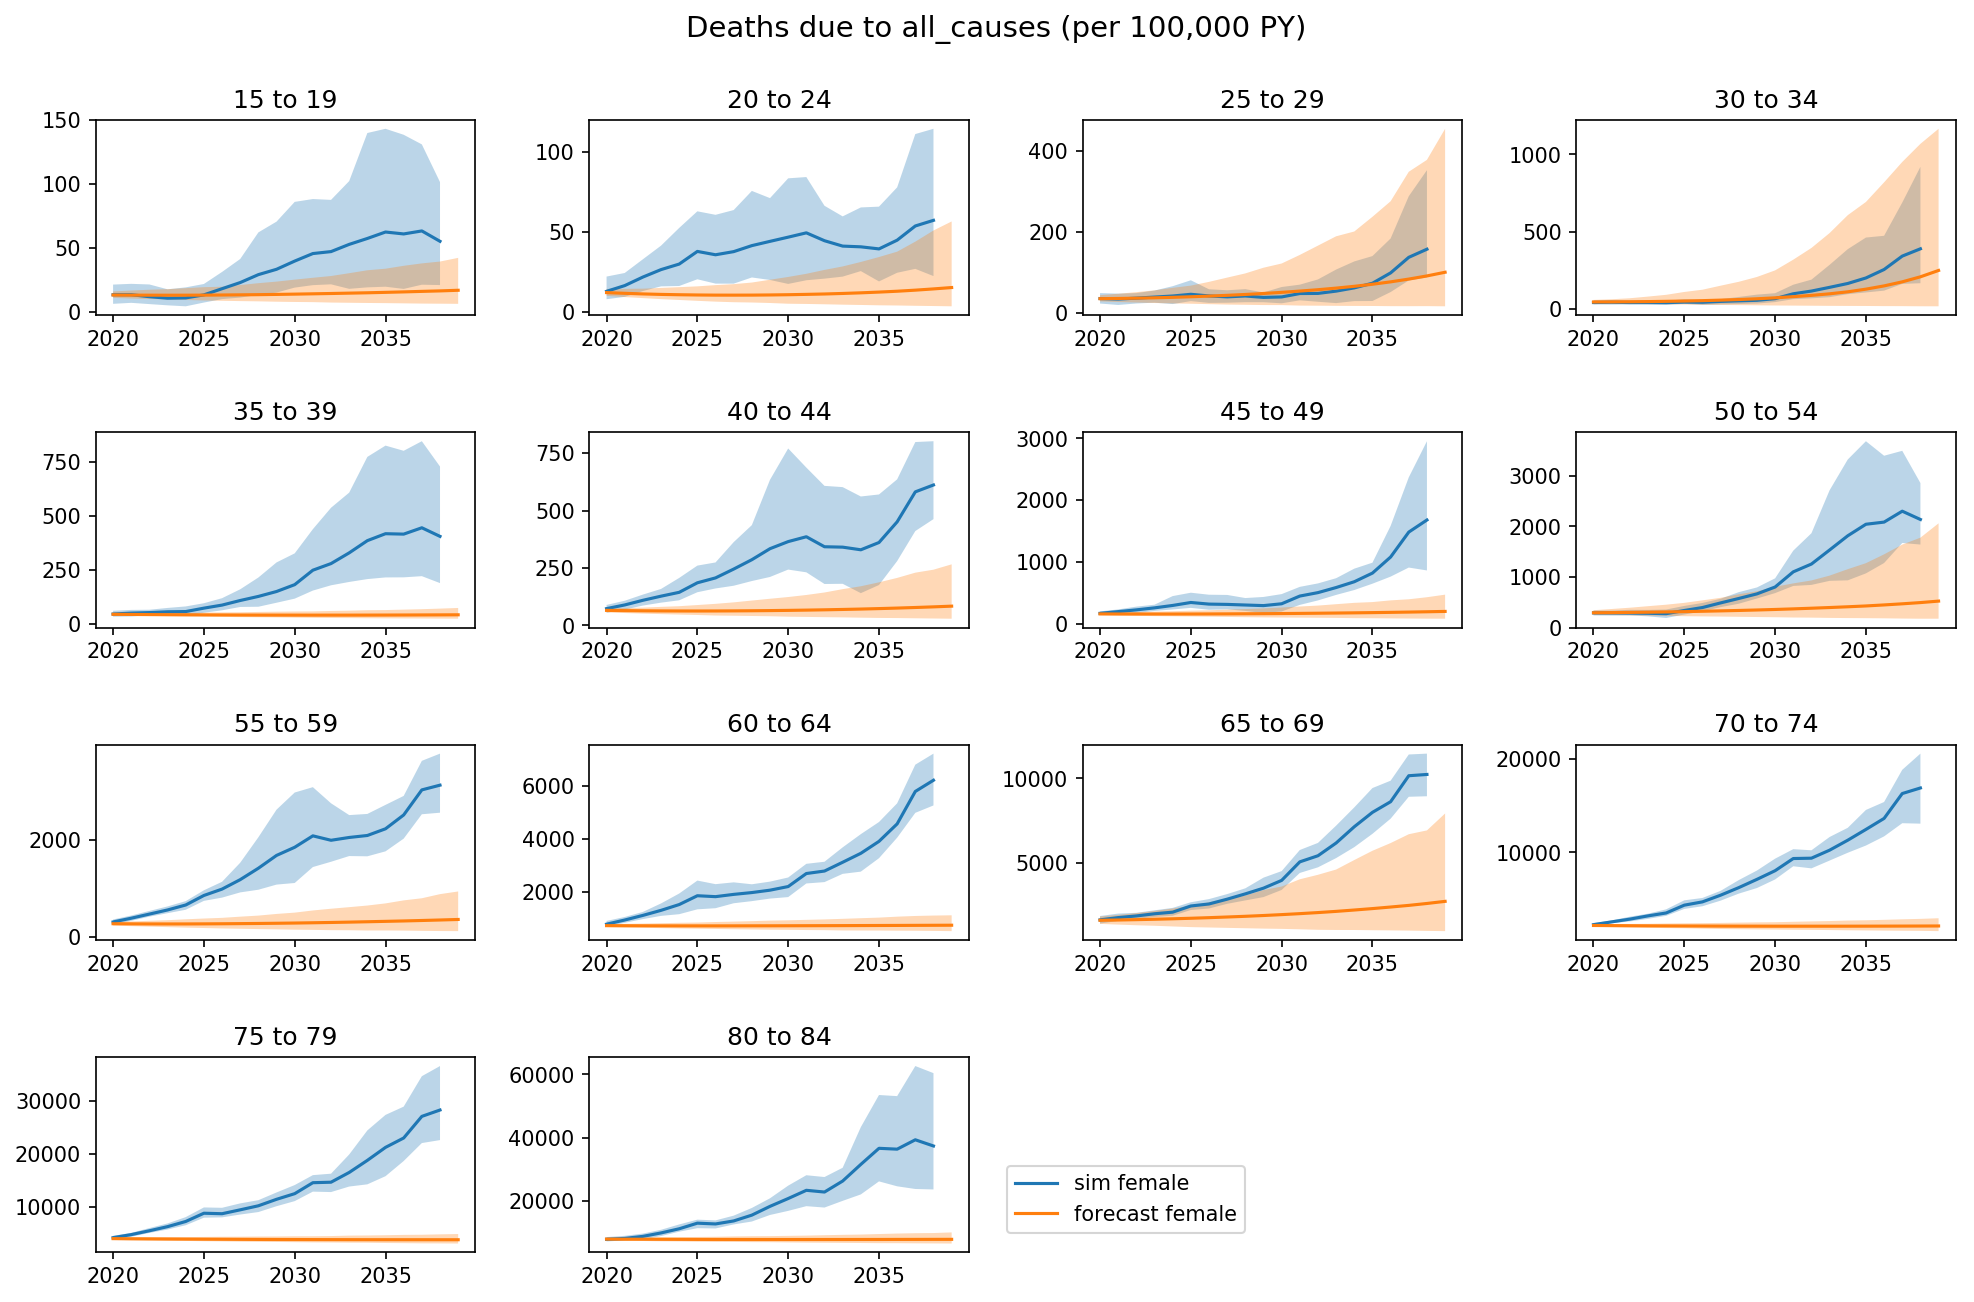

In [37]:
plot_sim_versus_forecast_by_year(csmr_summary, forecast['acmr_forecast'], 
                                 'Deaths', 'cause', 'all_causes', 'female')

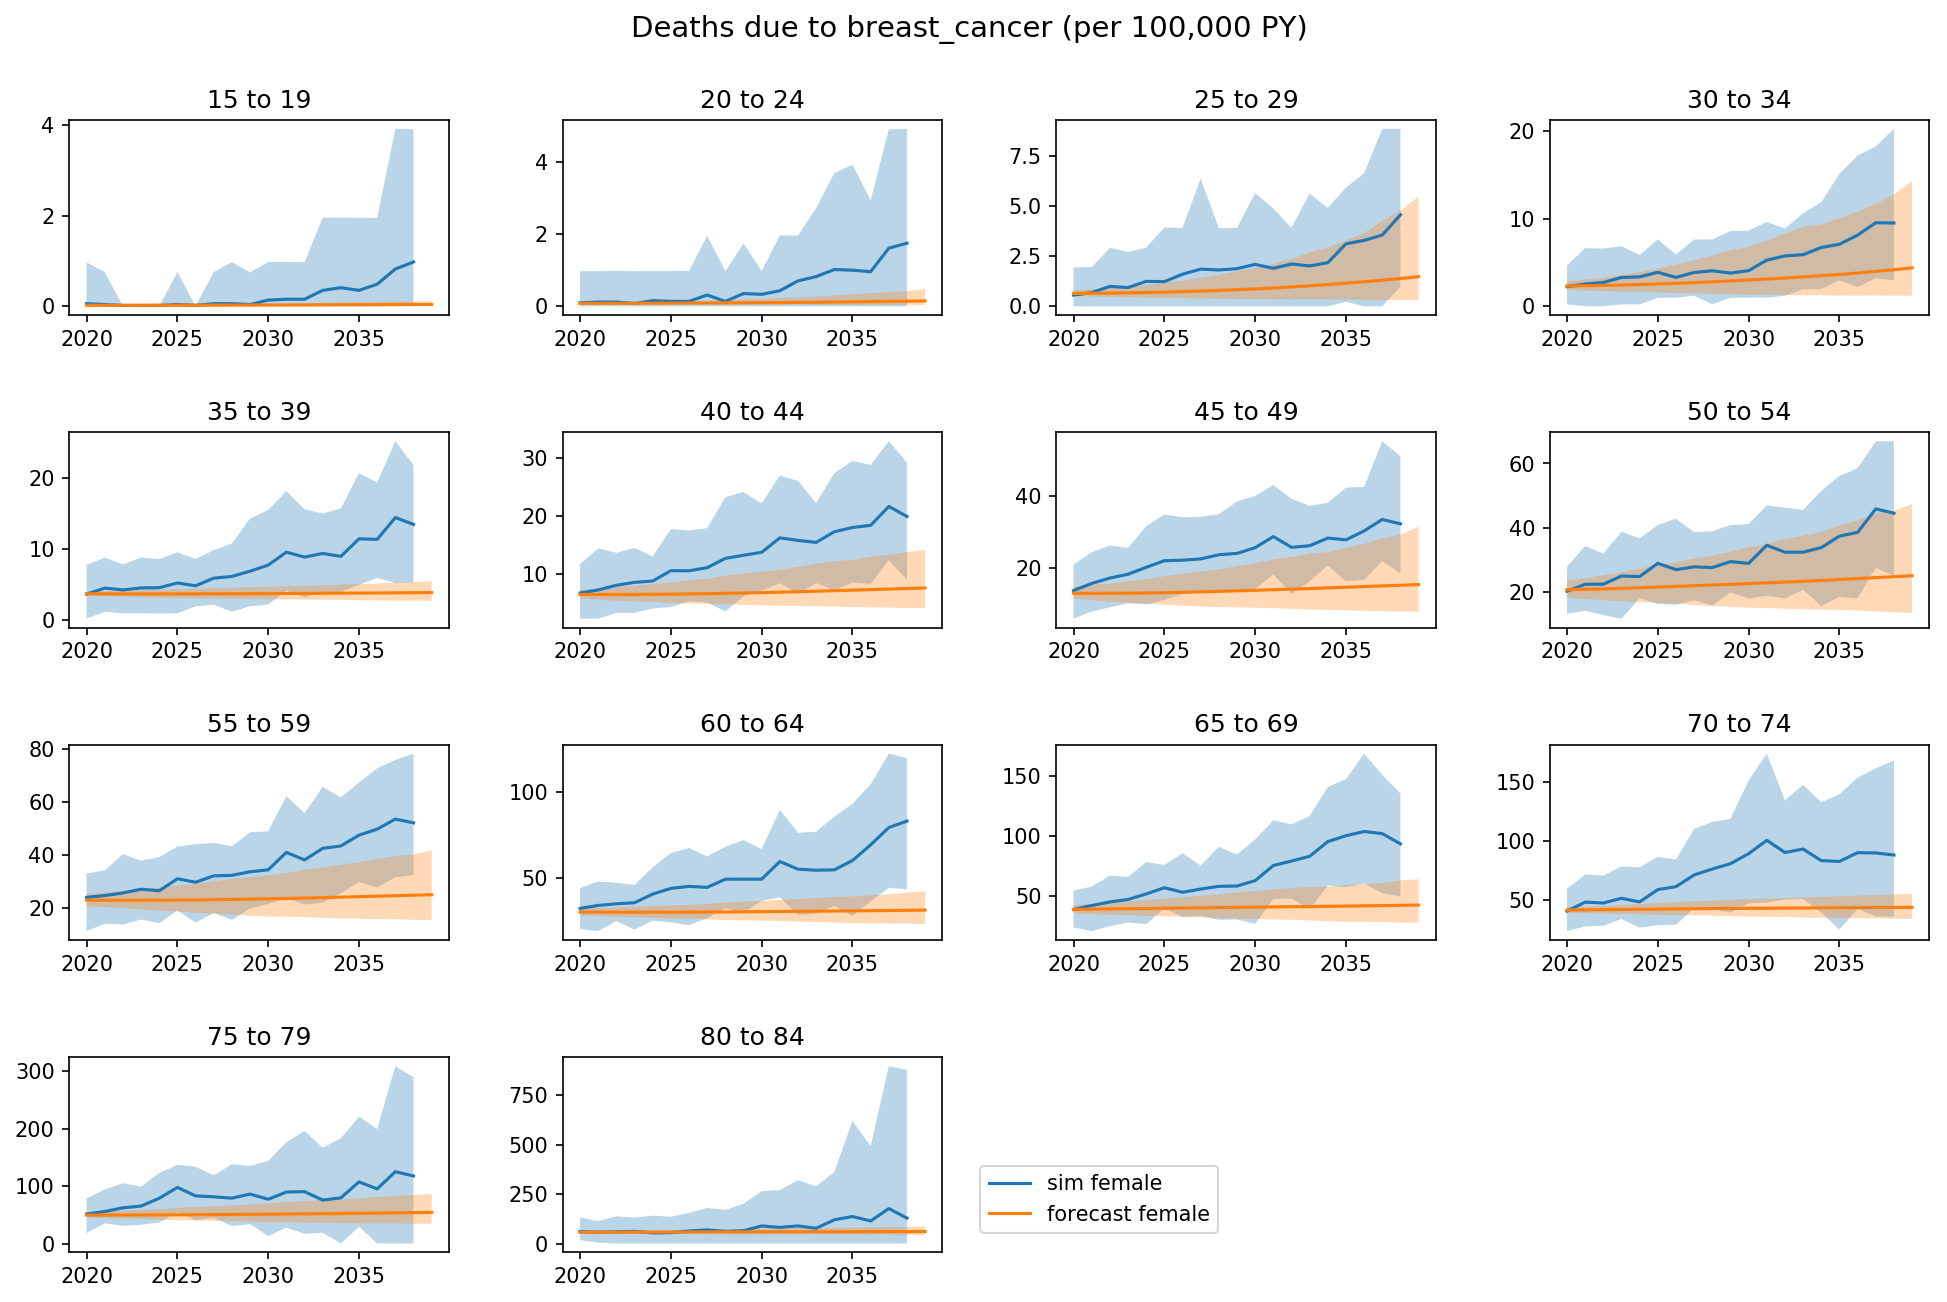

In [38]:
plot_sim_versus_forecast_by_year(csmr_summary, forecast['c429_csmr_forecast'], 
                                 'Deaths', 'cause', 'breast_cancer', 'female')

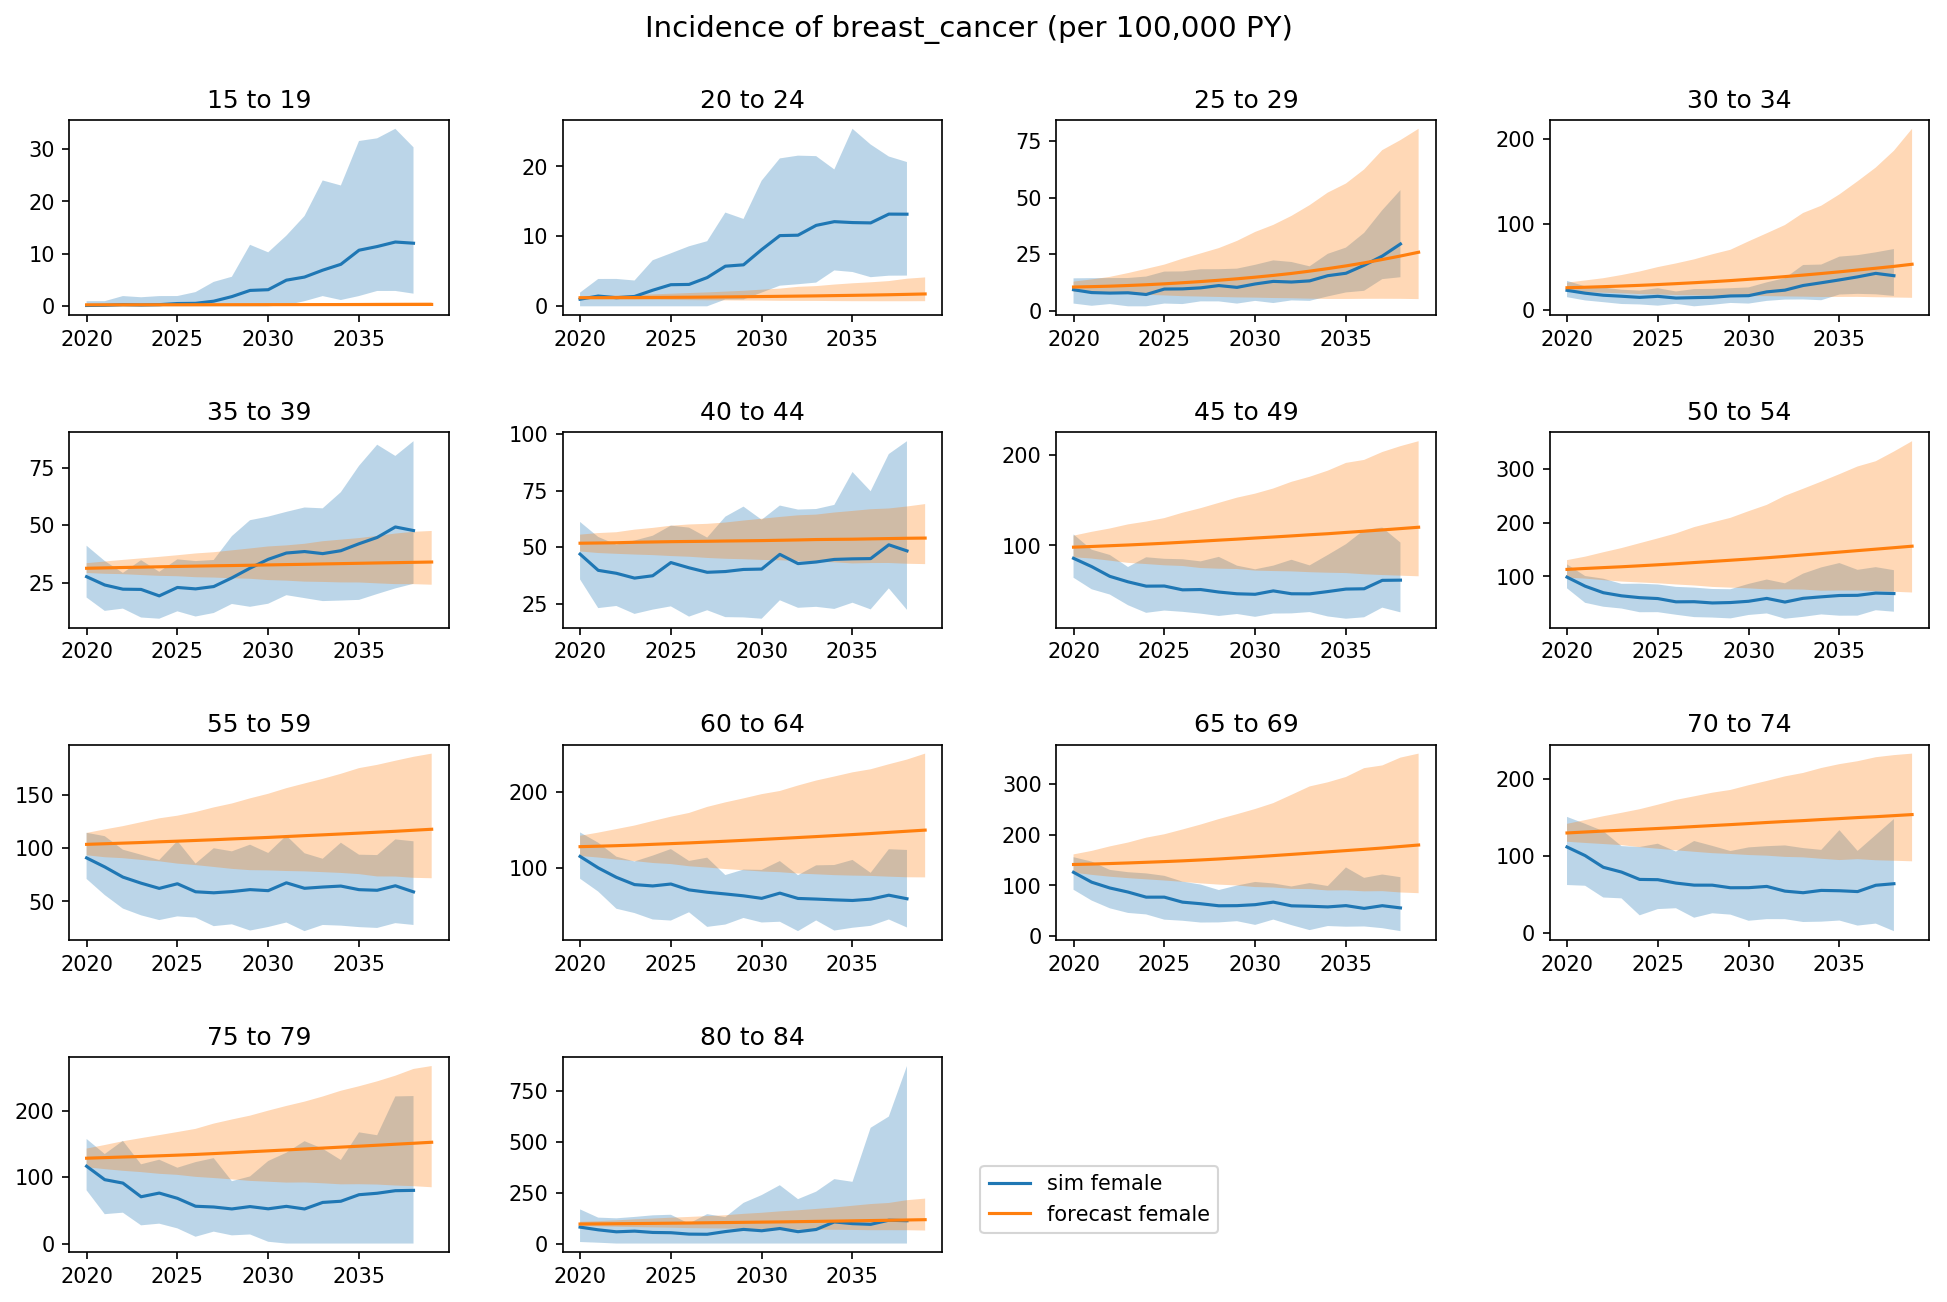

In [39]:
plot_sim_versus_forecast_by_year(incidence_rate_summary, forecast['c429_incidence_forecast'], 
                                 'Incidence', 'measure', 'breast_carcinoma_in_situ_to_breast_cancer_event_count', 'female')

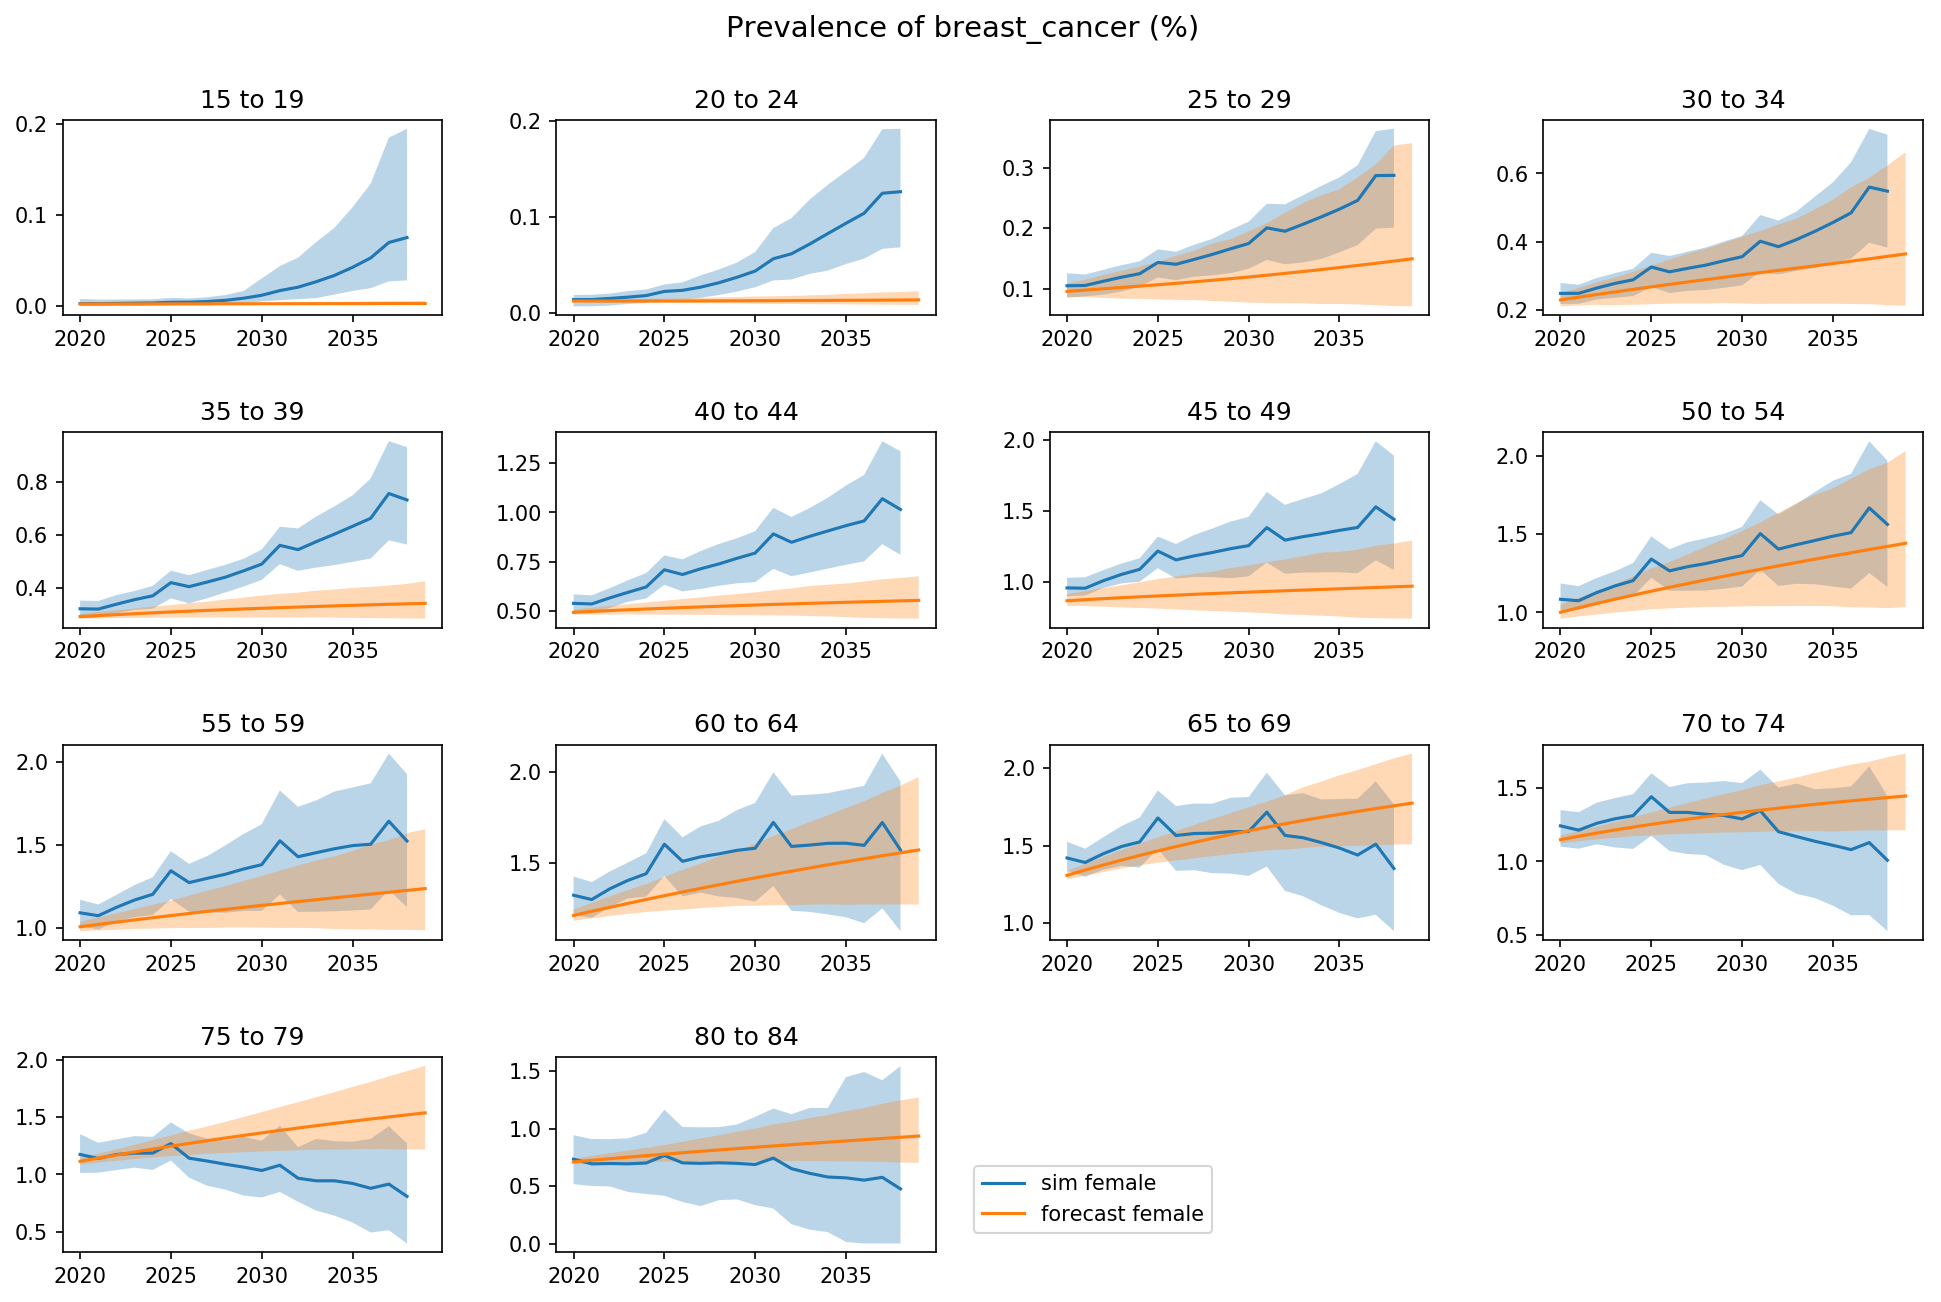

In [40]:
plot_sim_versus_forecast_by_year(prevalence_summary, forecast['c429_prev_forecast'], 
                                 'Prevalence', 'cause', 'breast_cancer', 'female')

In [41]:
def plot_sim_versus_forecast_by_age(sim: pd.DataFrame, forecast: pd.DataFrame, 
                                    measure: str, col_name: str, select: str, year: int):
    sim = sim.copy()
    sim['age'] = sim.age_cohort.map(age_names)
    sim_sub = sim[getattr(sim, col_name) == select]
    
    plt.figure(figsize=(16, 6), dpi=150)
    
    for i, sex in enumerate(['female', 'male']):
        plt.subplot(1, 2, i+1)
        plt.subplots_adjust(wspace=0.3)
        
        sim_sex = sim_sub[(sim_sub.year == year) & (sim_sub.sex == sex)]
        sim_sex = sim_sex.sort_values(by='age')
        forecast_sex = forecast[(forecast.year == year) & (forecast.sex == sex)]
        
        plt.plot(sim_sex['age'], sim_sex['mean'], marker='o', label='sim')
        plt.plot(forecast_sex['age'], forecast_sex['mean'], marker='o', label='forecast')
        plt.fill_between(sim_sex['age'], sim_sex['2.5%'], sim_sex['97.5%'], alpha=.3)
        plt.fill_between(forecast_sex['age'], forecast_sex['lb'], forecast_sex['ub'], alpha=.3)
        plt.xticks(rotation=60)
        plt.xlabel('Age group')
        plt.title(f'{sex}, {year}')
    plt.legend(loc=(1.1, .1))
    
    if measure == 'Deaths':
        plt.suptitle(f'{measure} due to {select} (per 100,000 PY)', y=1, fontsize=14)
    elif measure == 'Incidence':
        if select == 'breast_carcinoma_in_situ_to_breast_cancer_event_count':
            select = 'breast_cancer'
        plt.suptitle(f'{measure} of {select} (per 100,000 PY)', y=1, fontsize=14)
    else:
        plt.suptitle(f'{measure} of {select} (%)', y=1, fontsize=14)

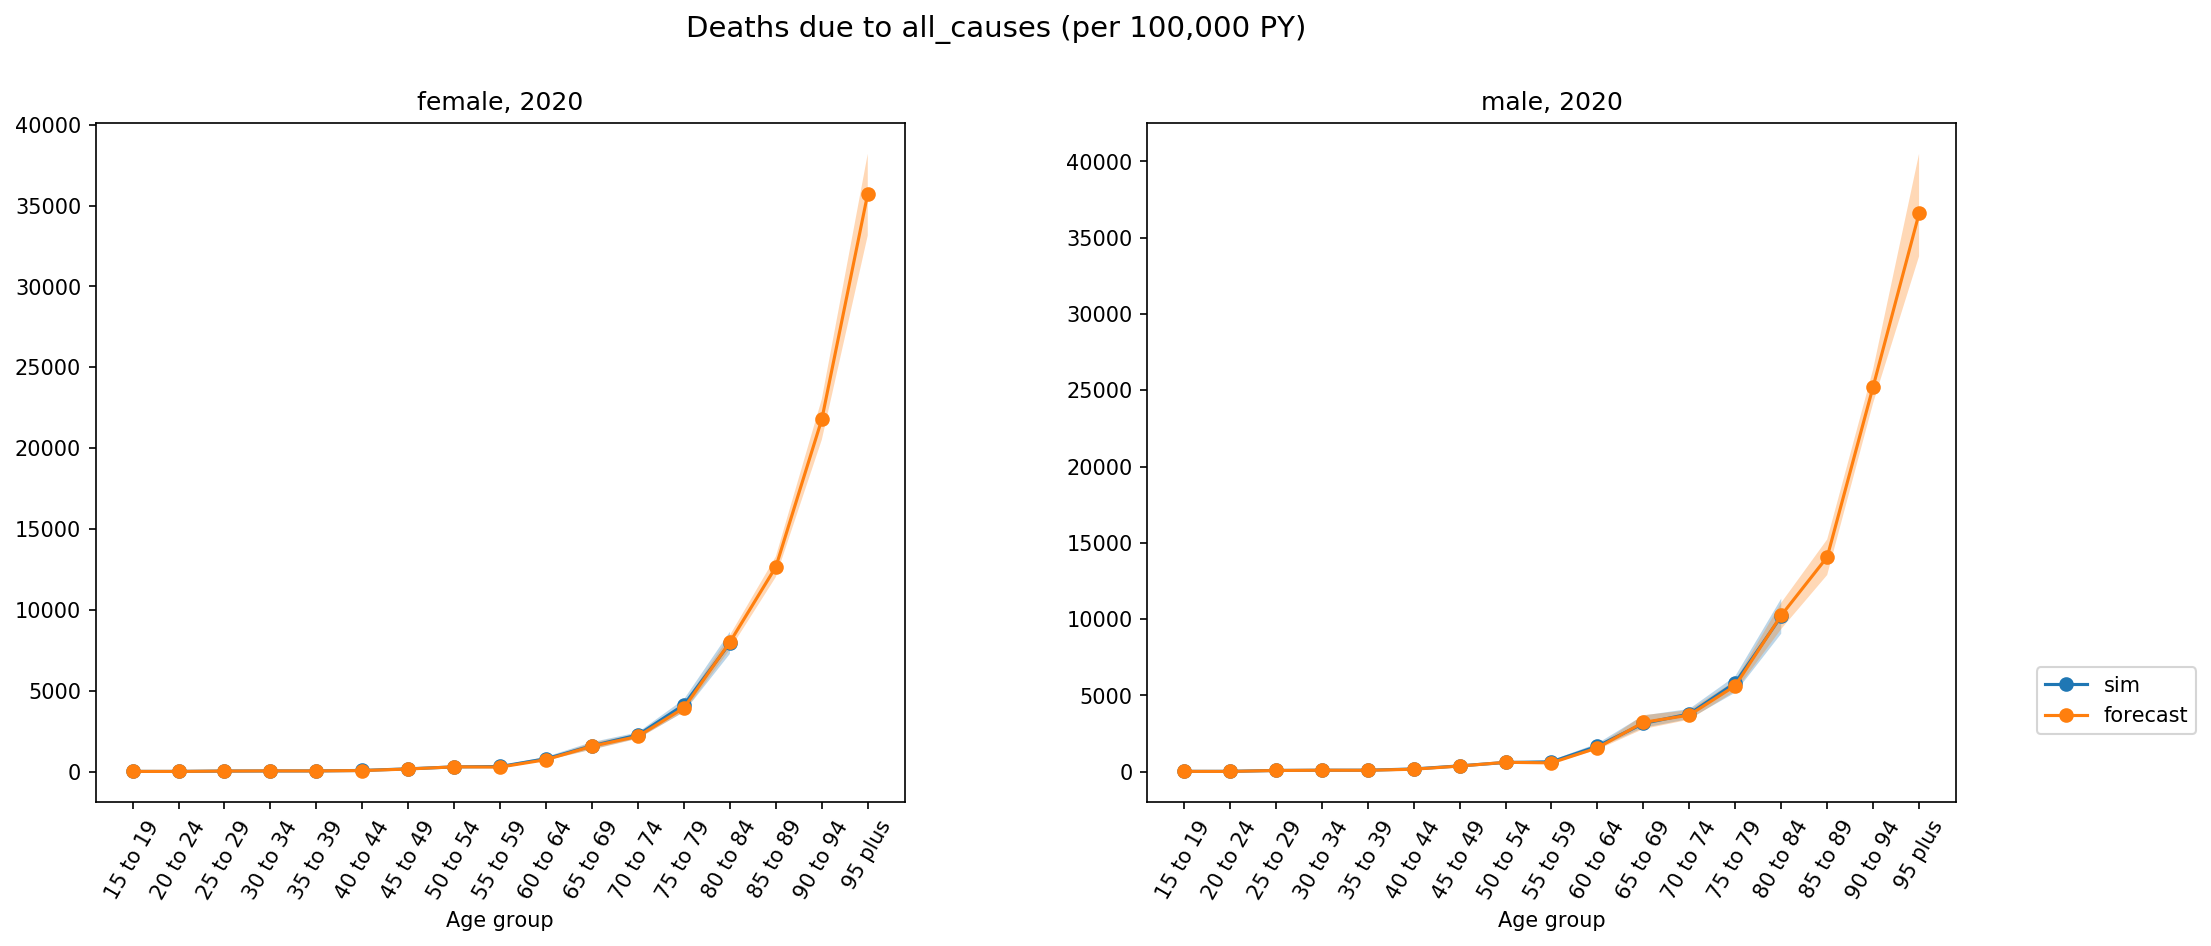

In [42]:
plot_sim_versus_forecast_by_age(csmr_summary, forecast['acmr_forecast'], 
                                'Deaths', 'cause', 'all_causes', 2020)

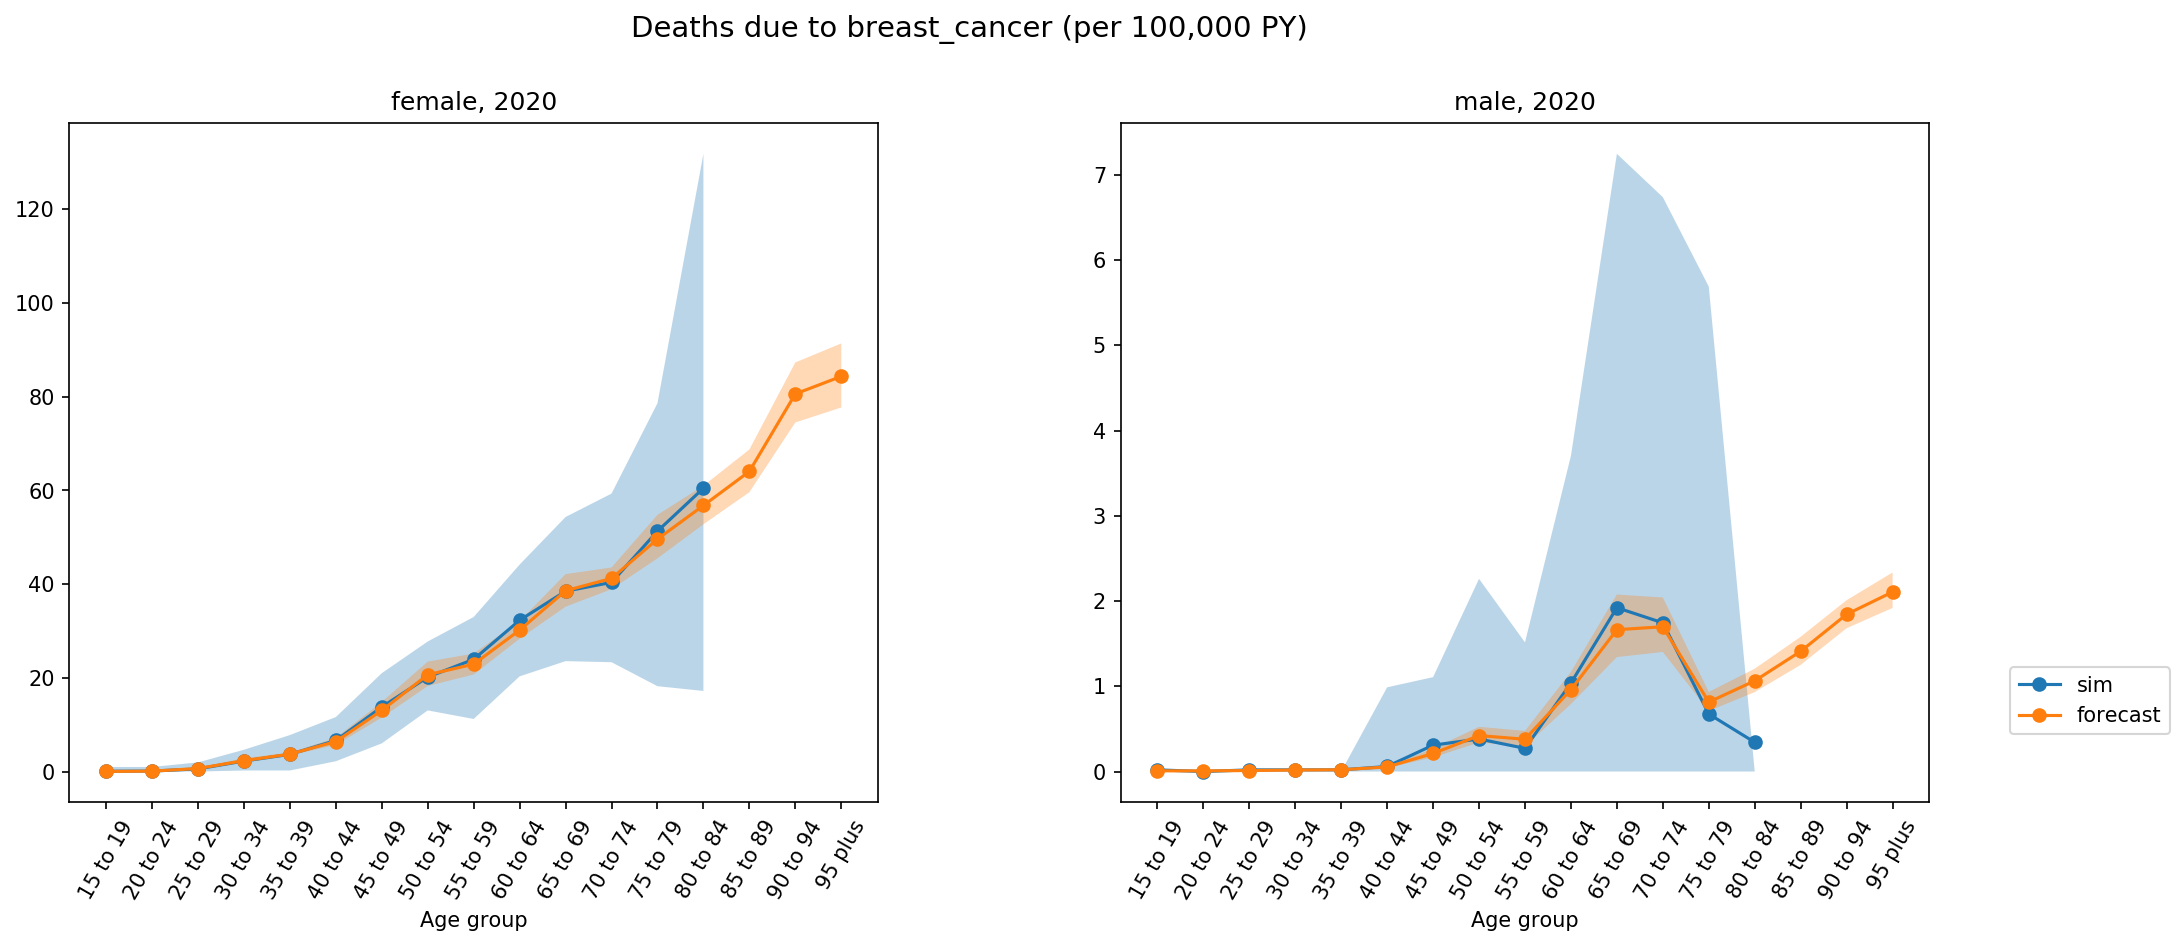

In [43]:
plot_sim_versus_forecast_by_age(csmr_summary, forecast['c429_csmr_forecast'], 
                                'Deaths', 'cause', 'breast_cancer', 2020)

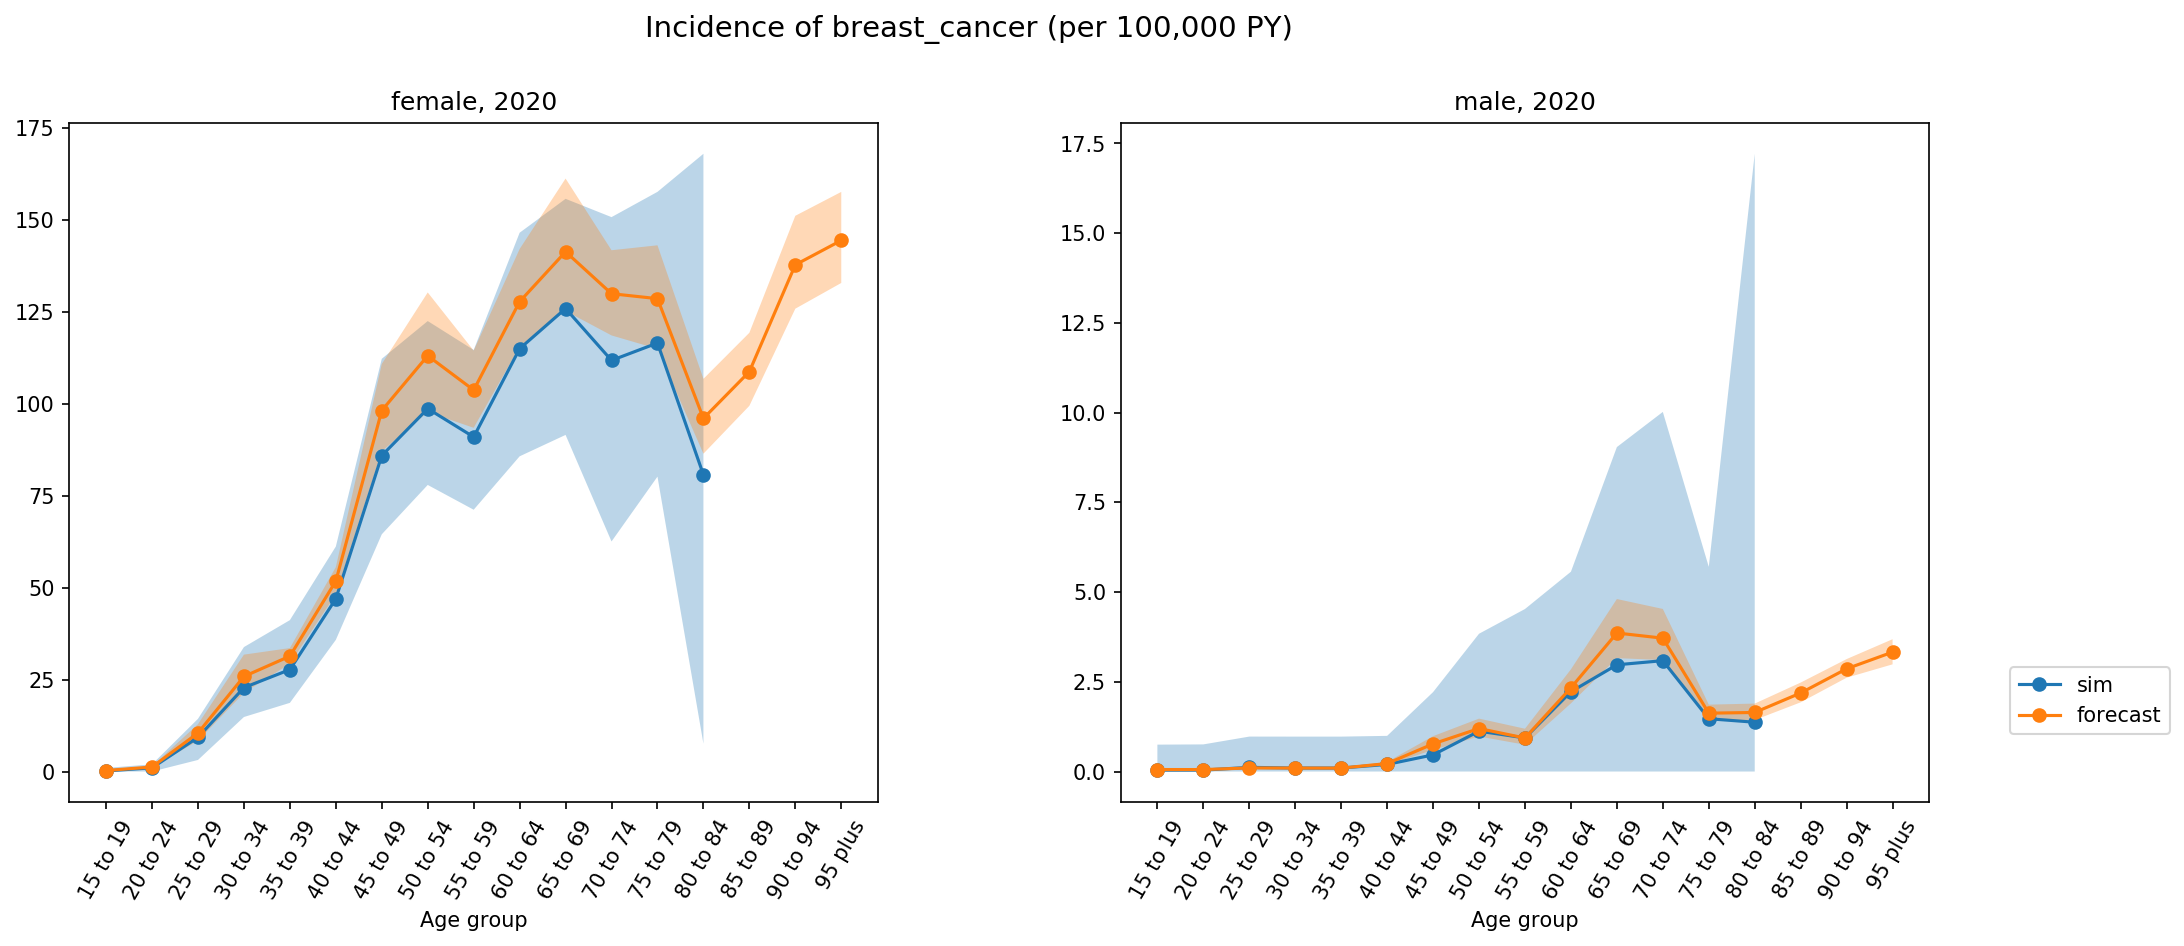

In [44]:
plot_sim_versus_forecast_by_age(incidence_rate_summary, forecast['c429_incidence_forecast'], 
                                'Incidence', 'measure', 'breast_carcinoma_in_situ_to_breast_cancer_event_count', 2020)

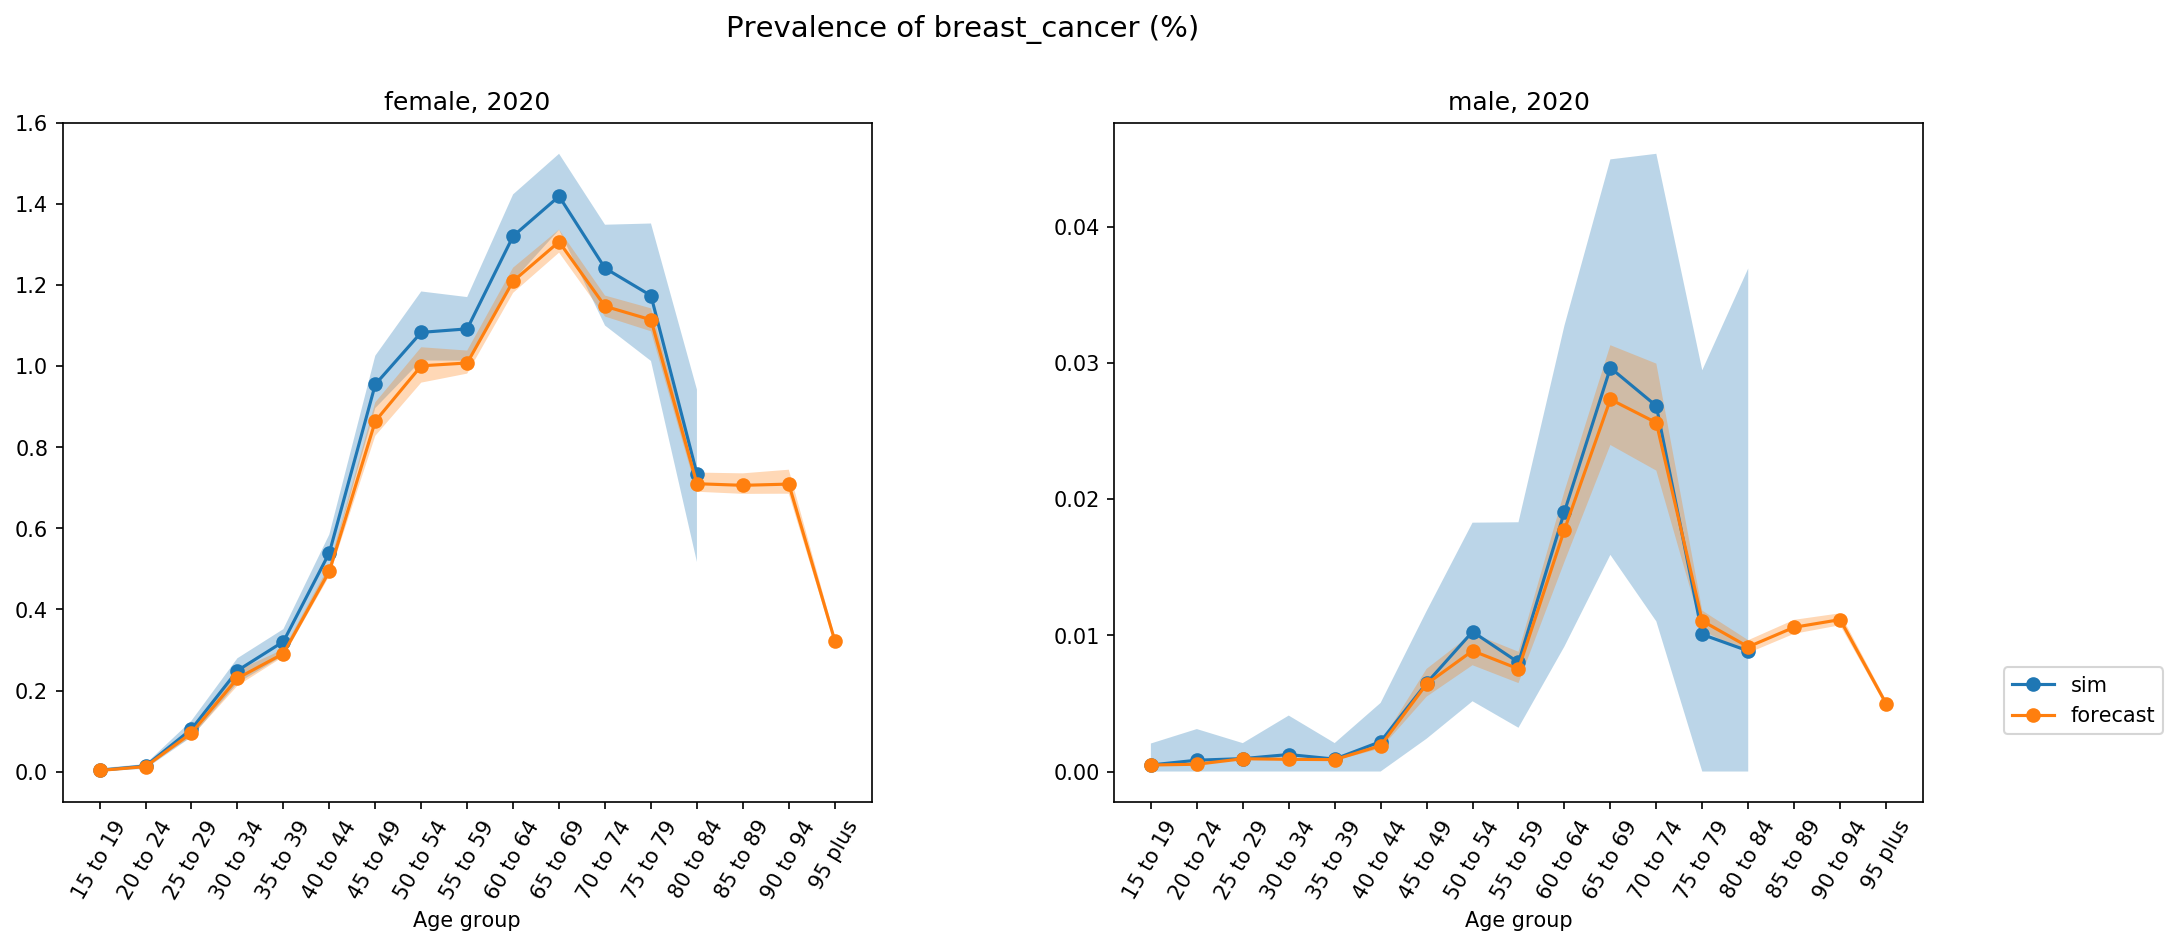

In [45]:
plot_sim_versus_forecast_by_age(prevalence_summary, forecast['c429_prev_forecast'], 
                                'Prevalence', 'cause', 'breast_cancer', 2020)